In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
import pickle

# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

root_path = '/content/drive/MyDrive/2024/Tópicos especiais de IA (2024.2) /DeepOnet /Dados salvos do treinamento /'

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0


In [ ]:
!pip install tensorflow==2.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
# Problem set up

sensors = 80

# Creating Data

## U samples

In [ ]:
def crate_samples_cos(u_sample_num, sensors):
  X_sample =  np.linspace(0, 1, sensors)
  u_sample = {}
  coef = {}
  for i in range(0, u_sample_num):
    n1 = np.random.randint(-5, 5)
    n2 = np.random.randint(-5, 5)
    n3 = np.random.randint(-5, 5)
    n4 = np.random.randint(-5, 5)
    u = (np.sin(n1*X_sample*np.pi) + np.sin(n2*X_sample*np.pi) + np.sin(n3*X_sample*np.pi) +np.sin(n4*X_sample*np.pi))/4
    #norm = max(abs(u))
    u_sample[f'{i}'] = tf.convert_to_tensor(u, dtype=tf.float32)
    coef[f'{i}'] = [n1, n2, n3, n4]

  return u_sample, coef

In [ ]:
u_sample, coef = crate_samples_cos(u_sample_num=100, sensors=sensors)
X_sample =  np.linspace(0, 1, sensors).reshape(-1, 1)
u_sample['0'].shape

TensorShape([80])

In [ ]:
i = 0
coef[f'{i}'][0]

-1

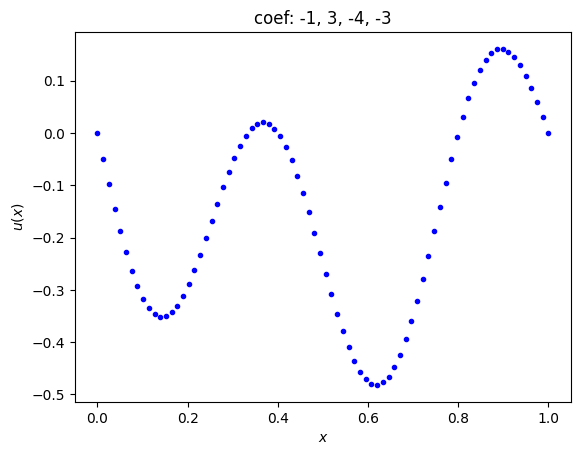

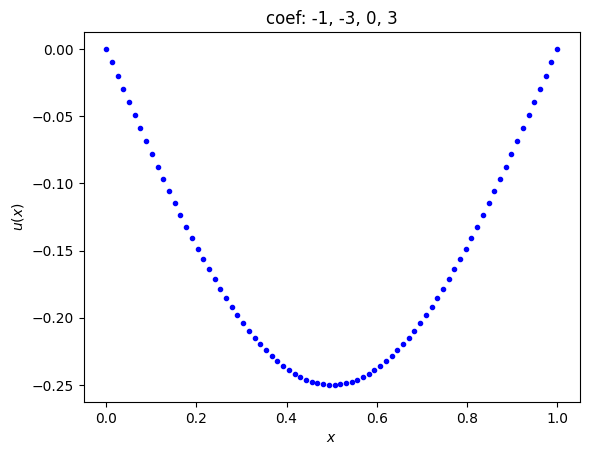

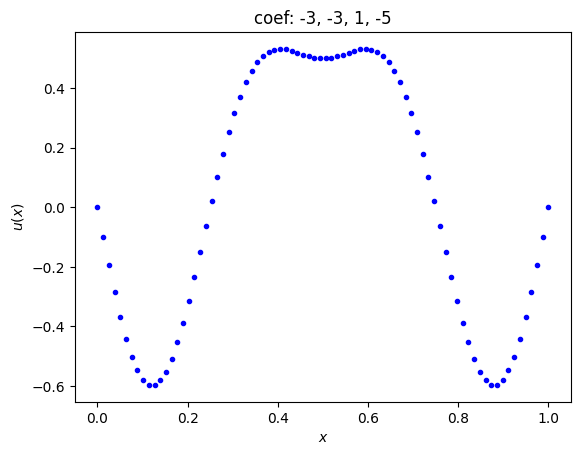

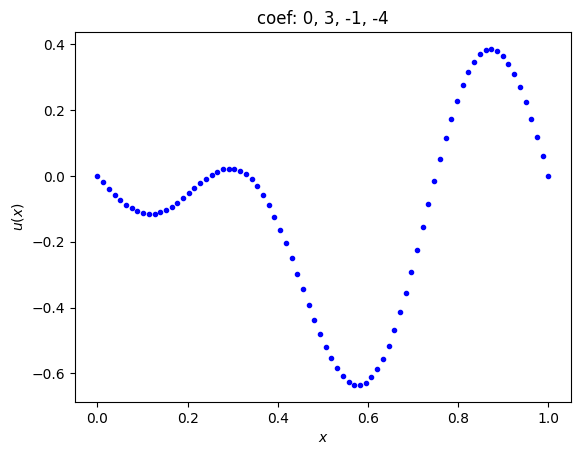

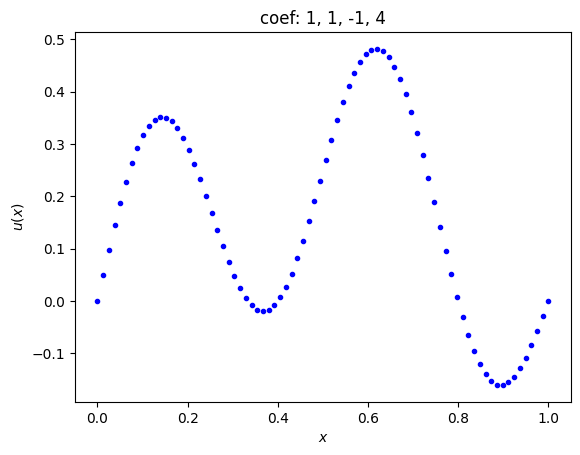

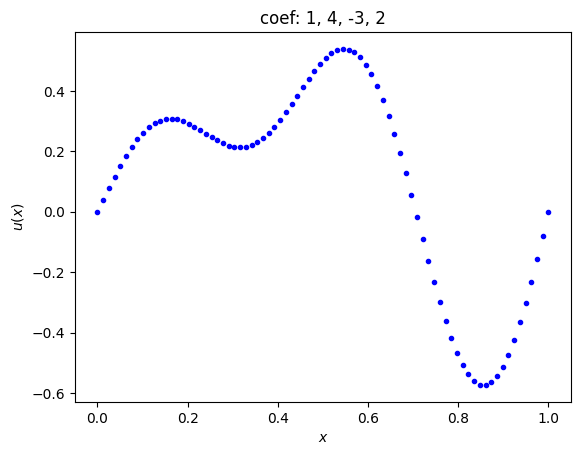

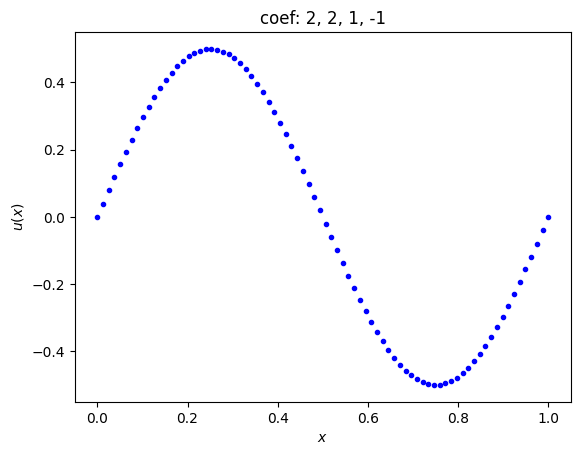

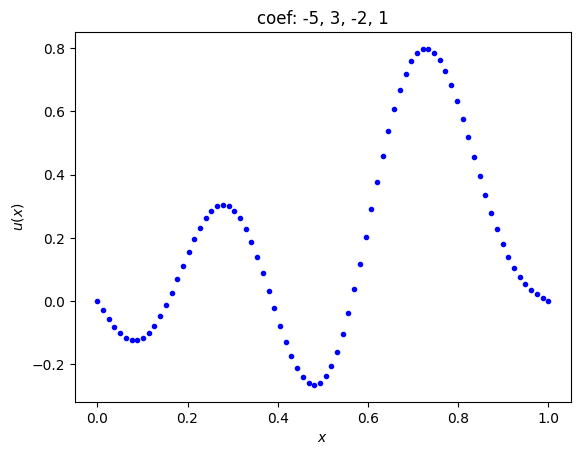

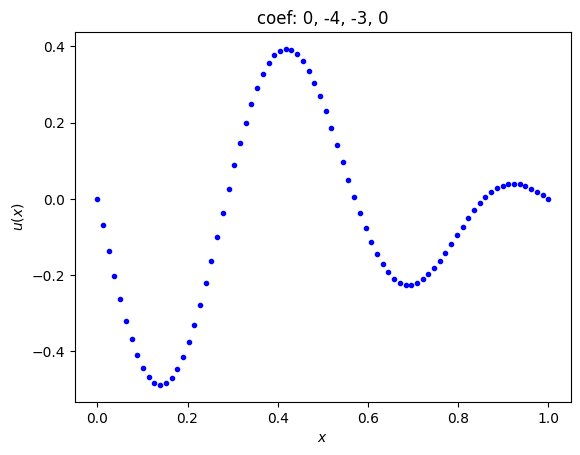

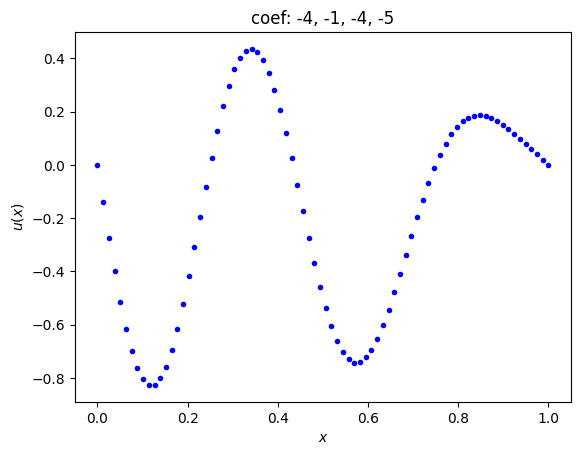

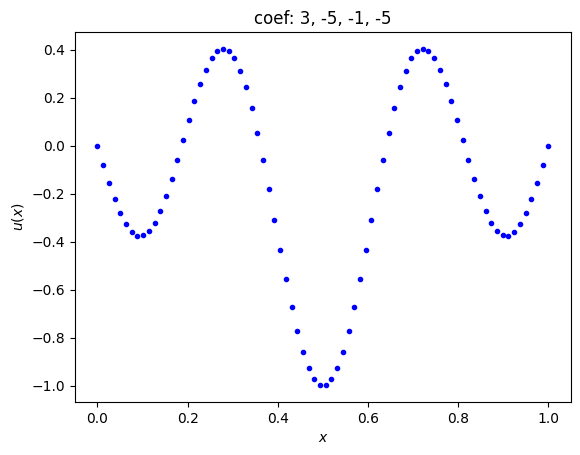

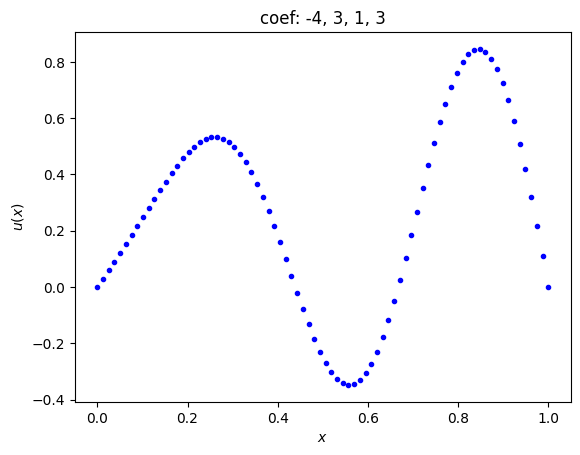

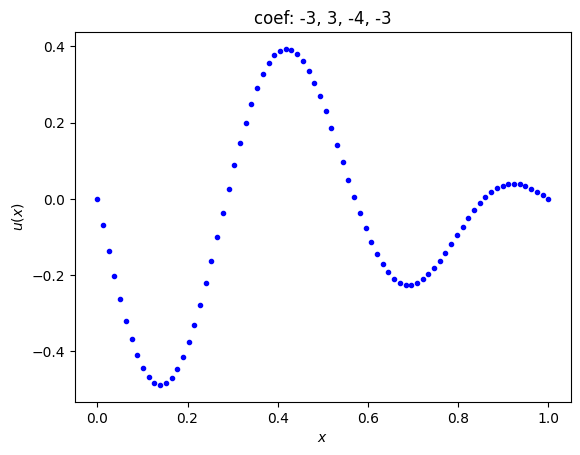

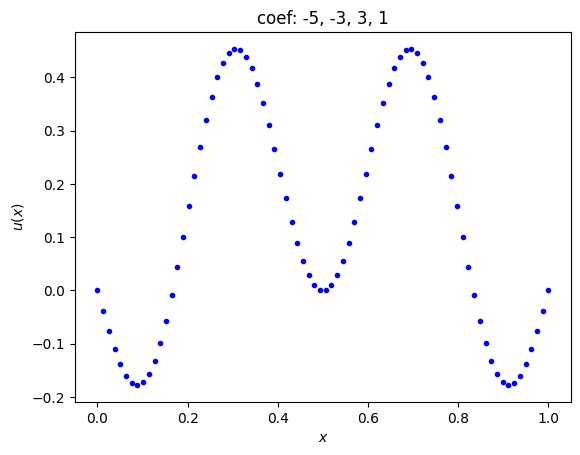

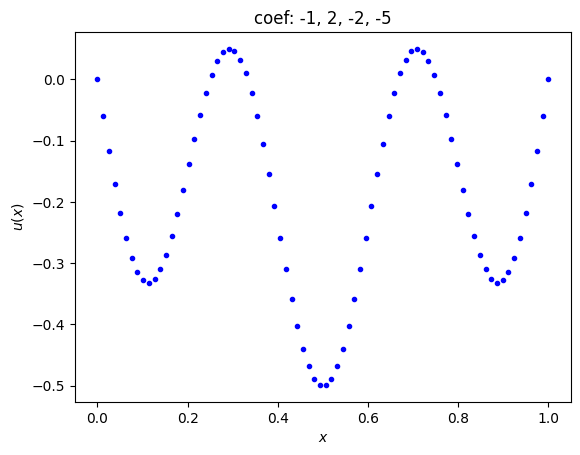

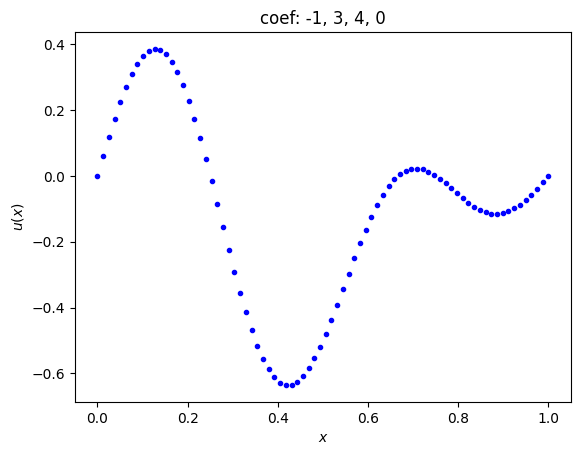

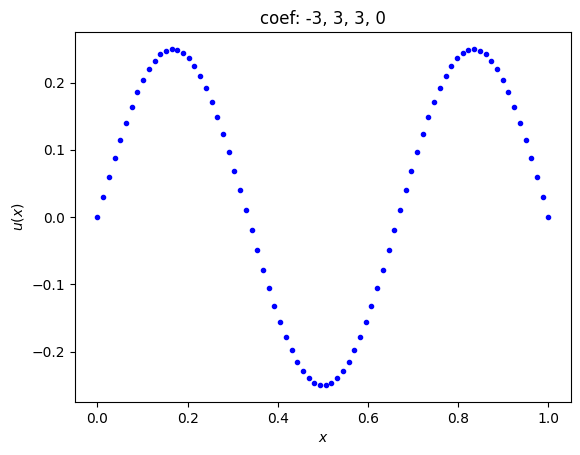

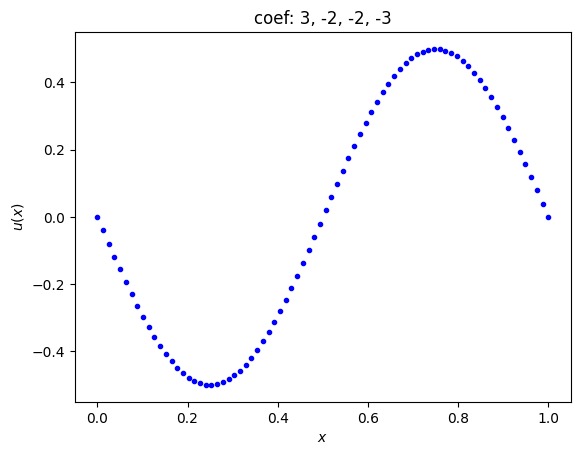

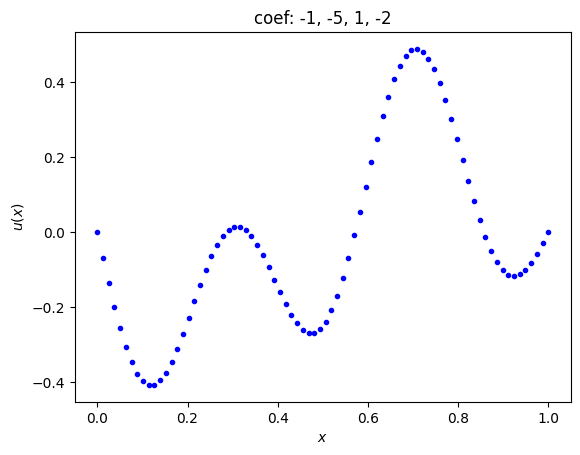

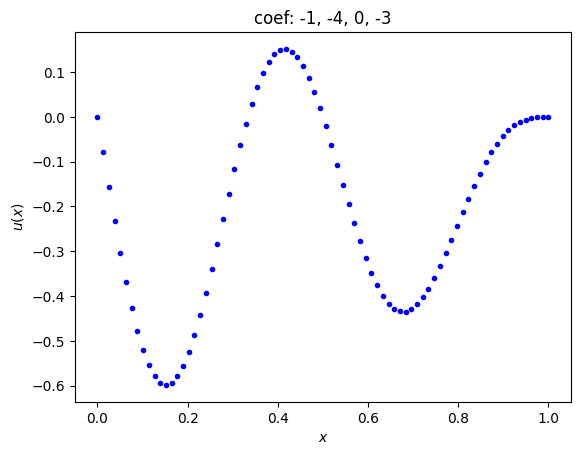

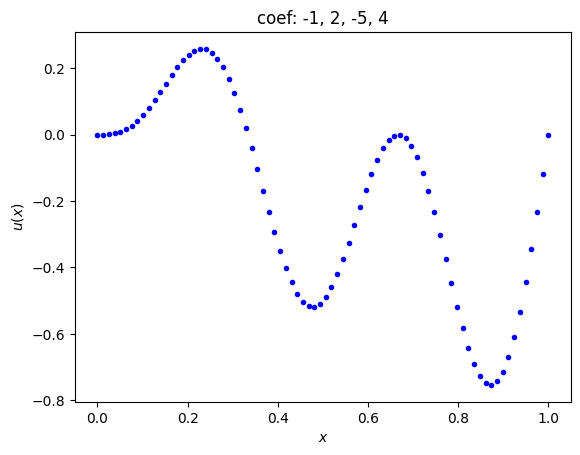

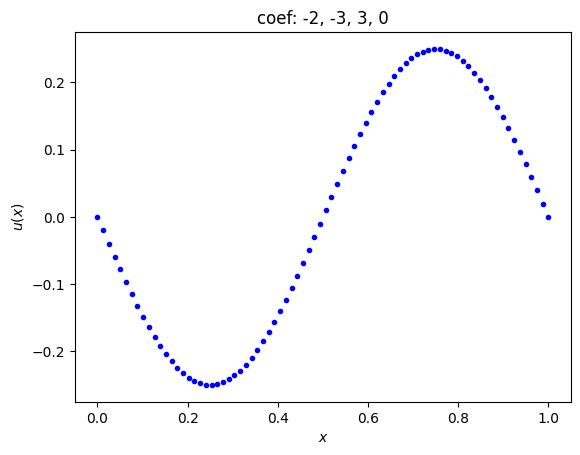

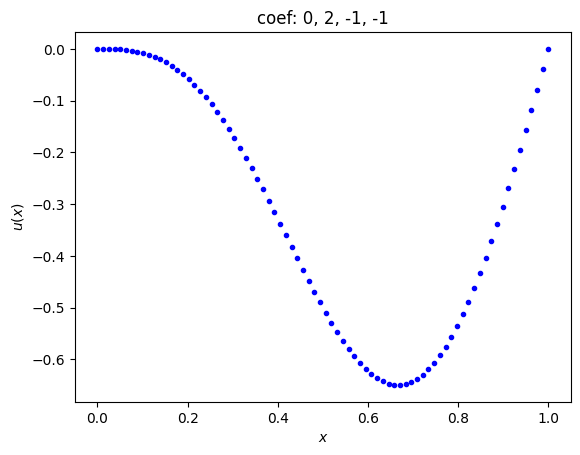

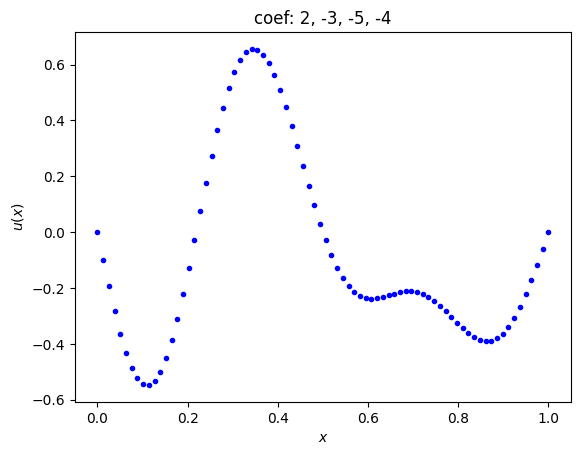

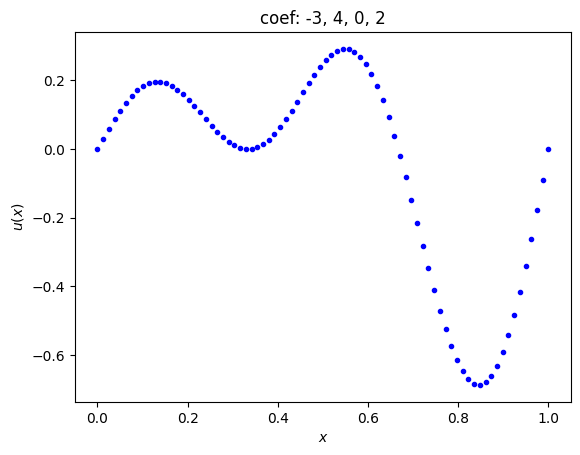

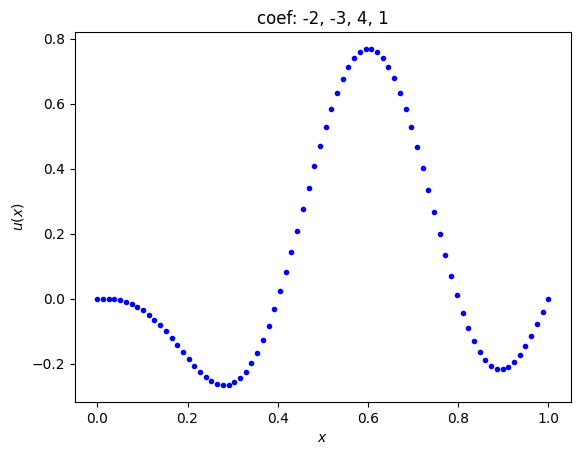

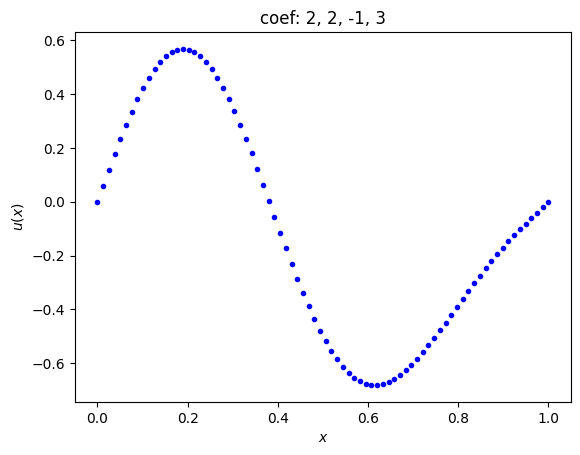

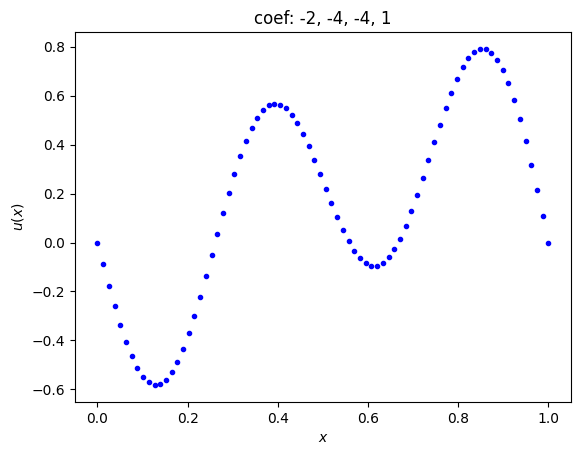

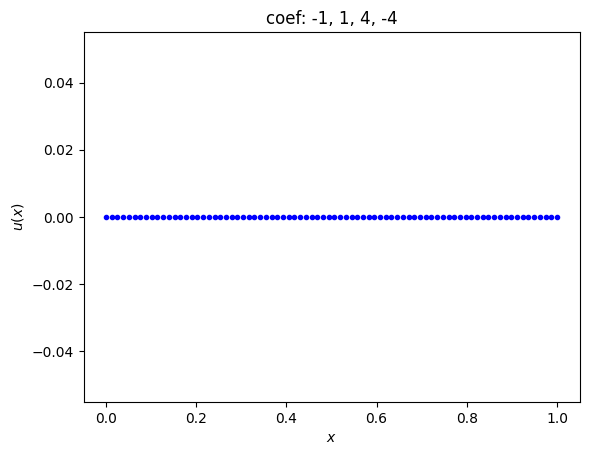

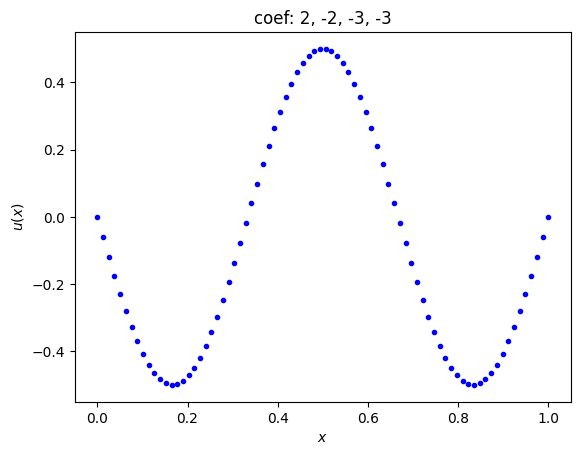

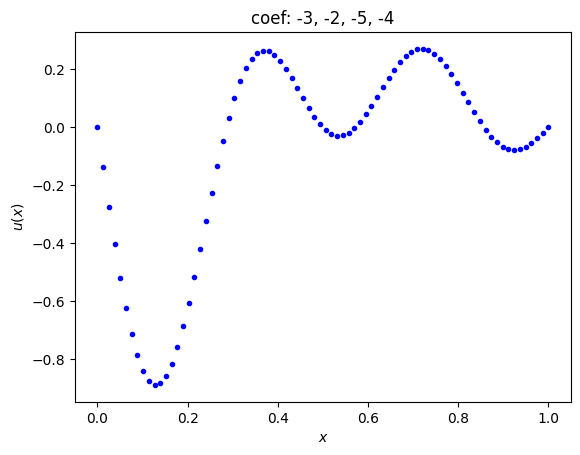

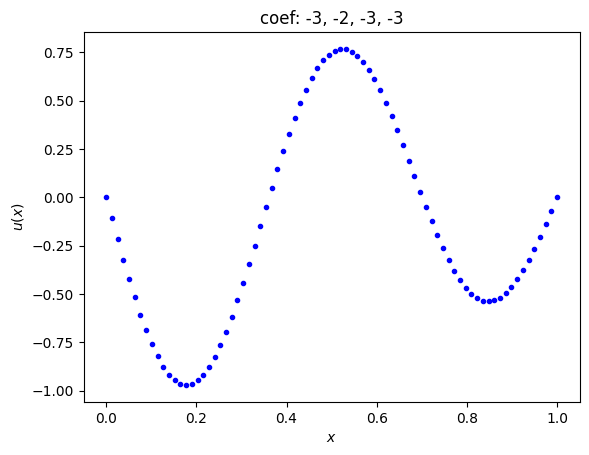

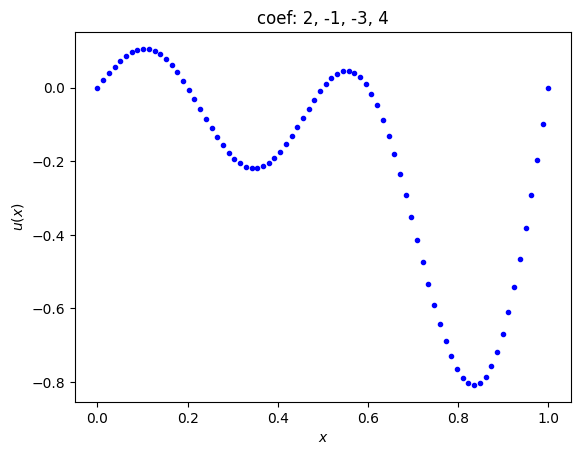

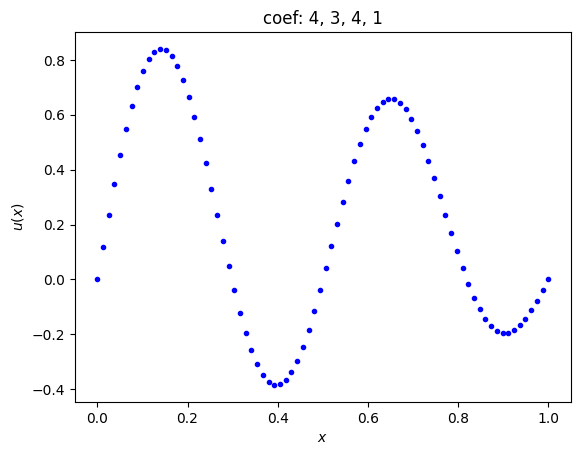

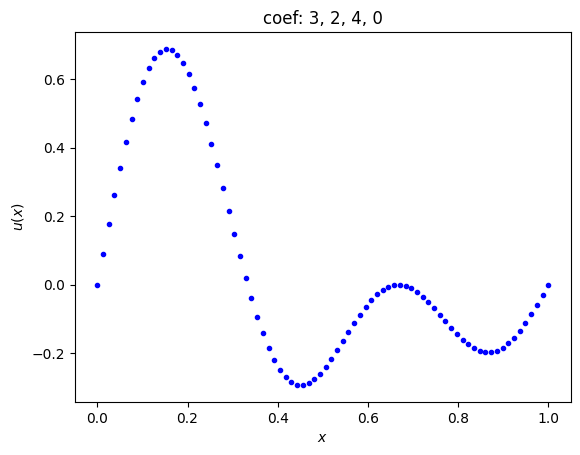

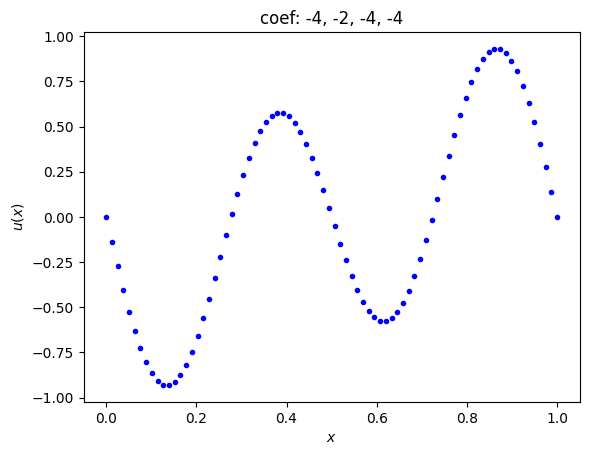

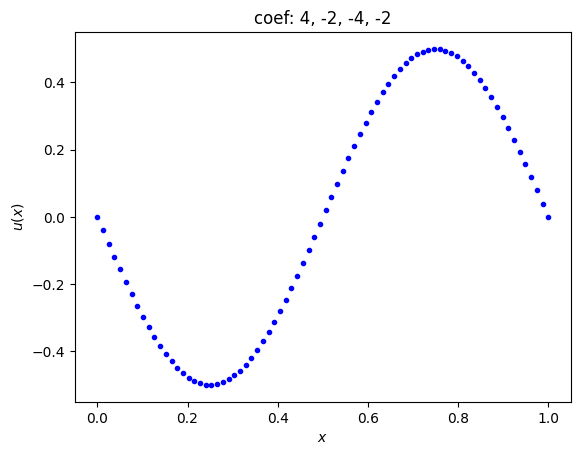

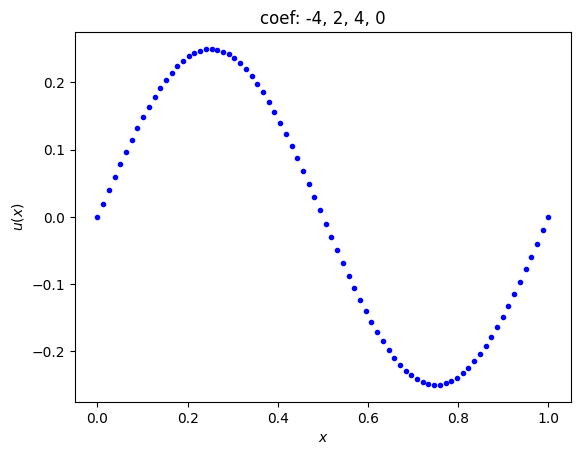

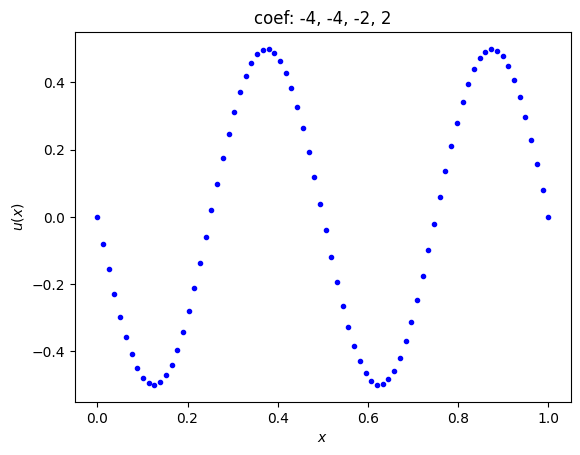

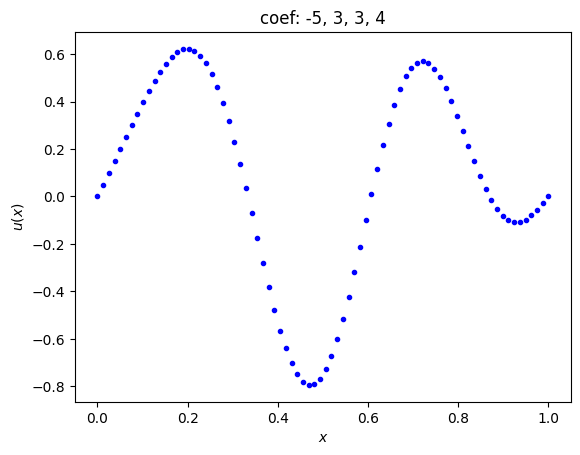

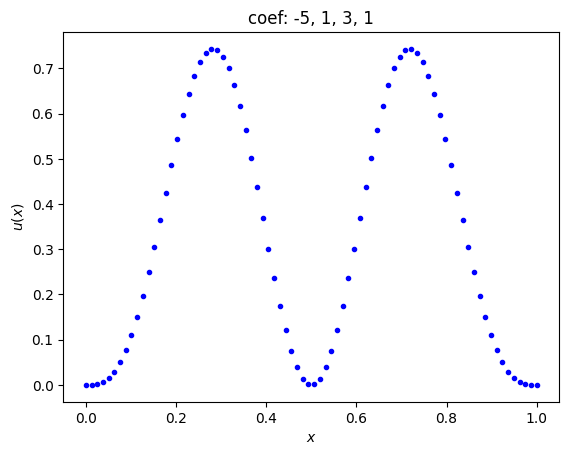

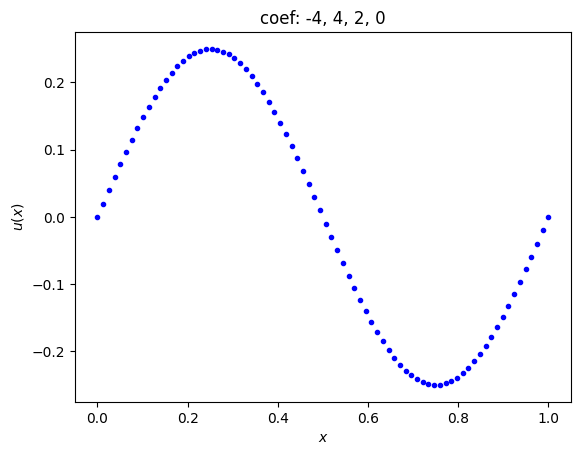

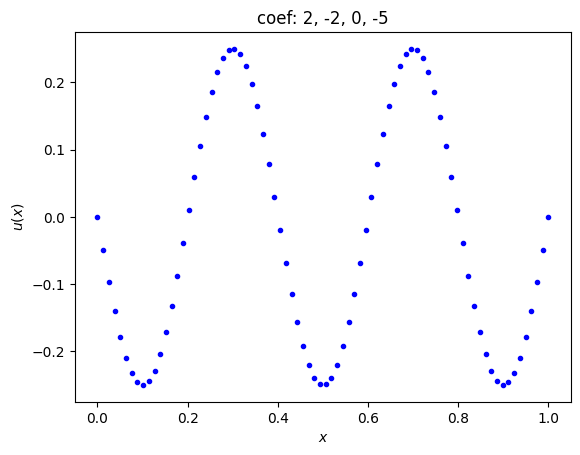

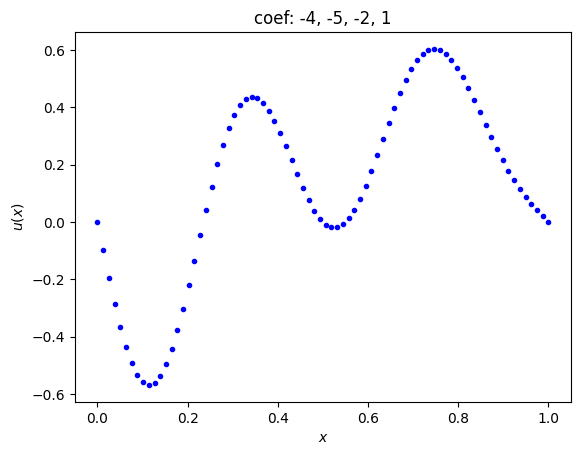

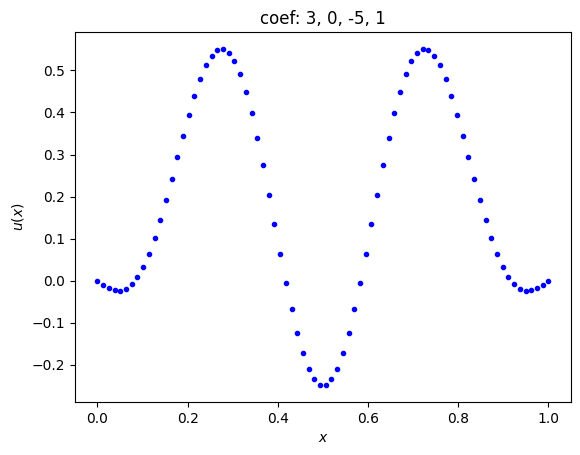

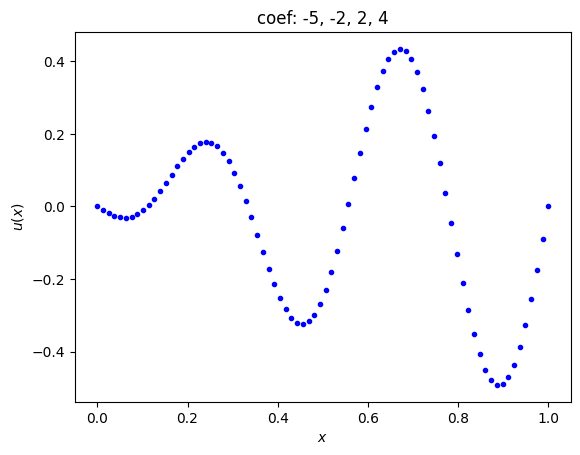

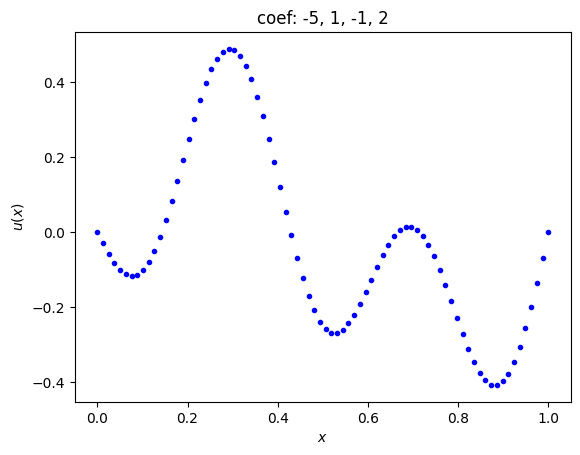

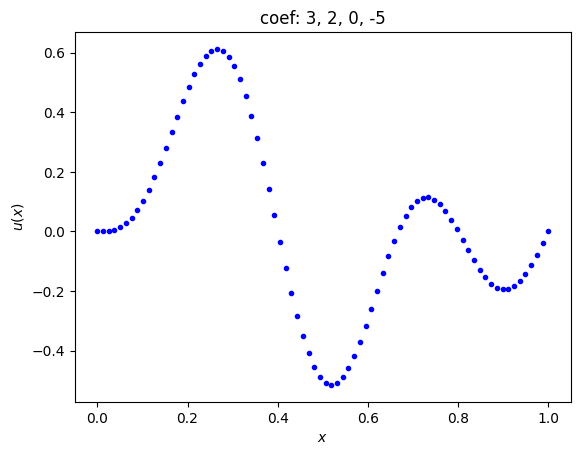

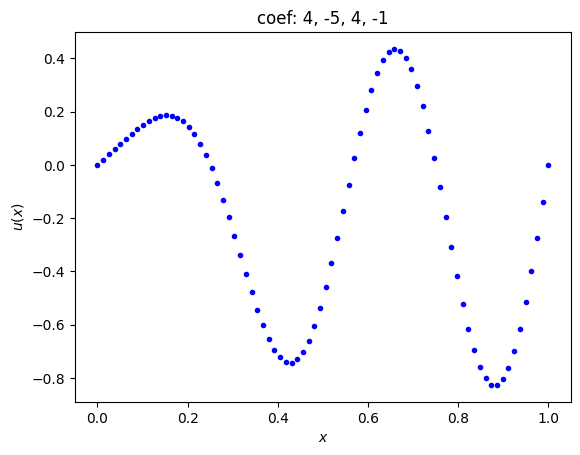

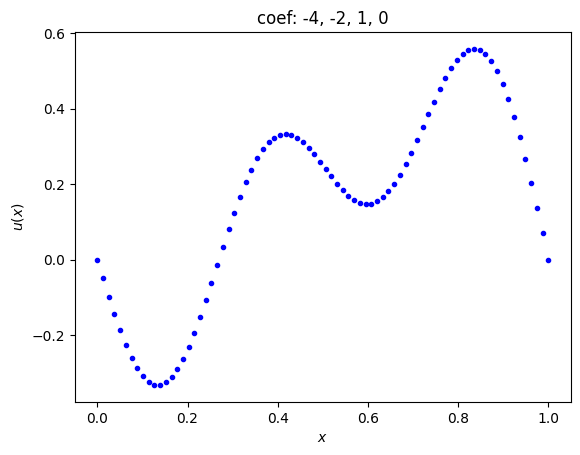

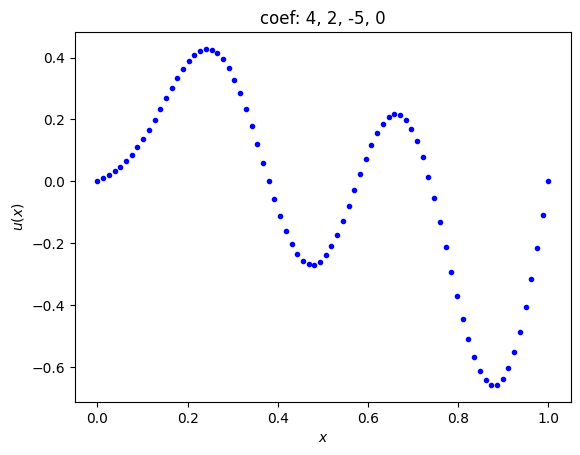

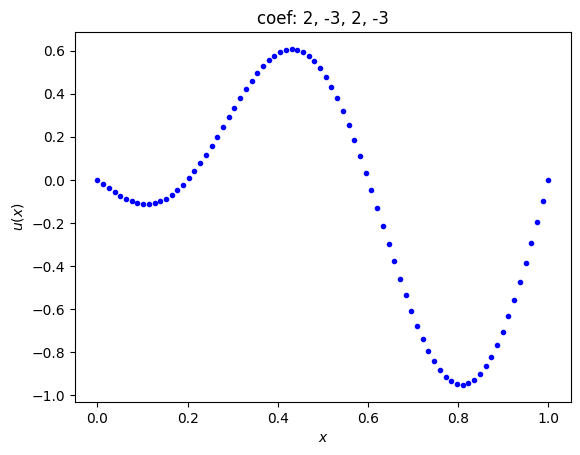

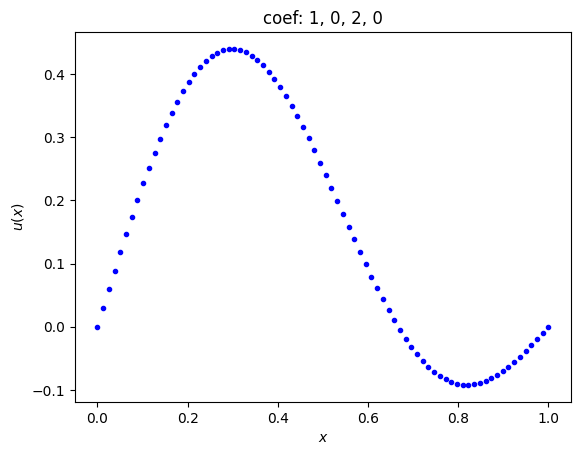

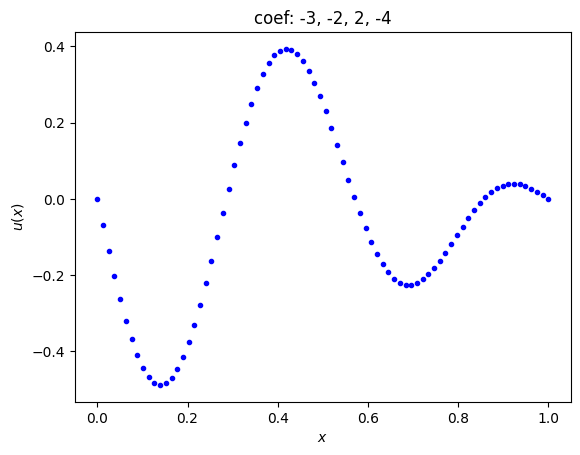

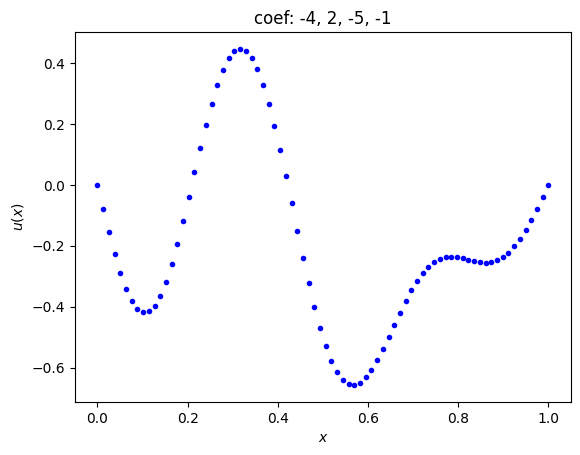

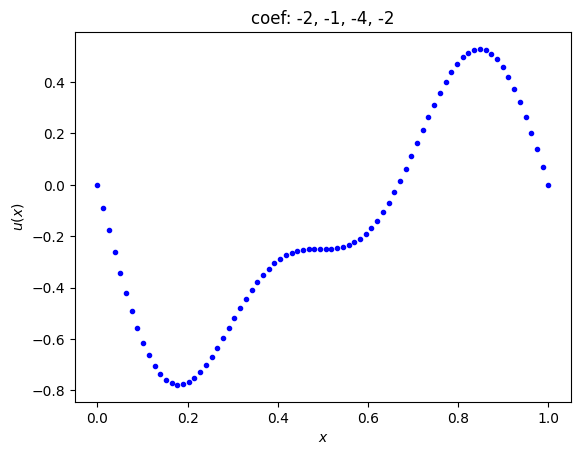

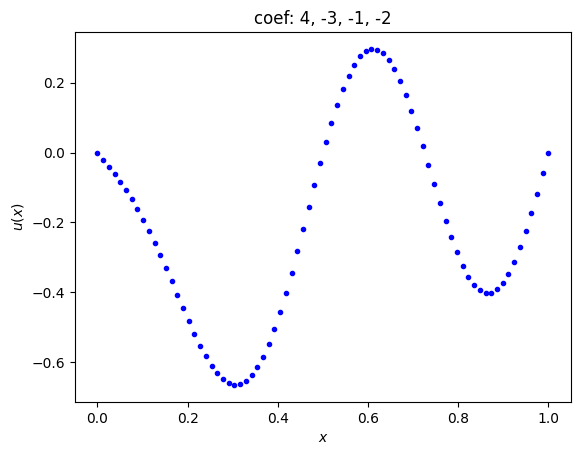

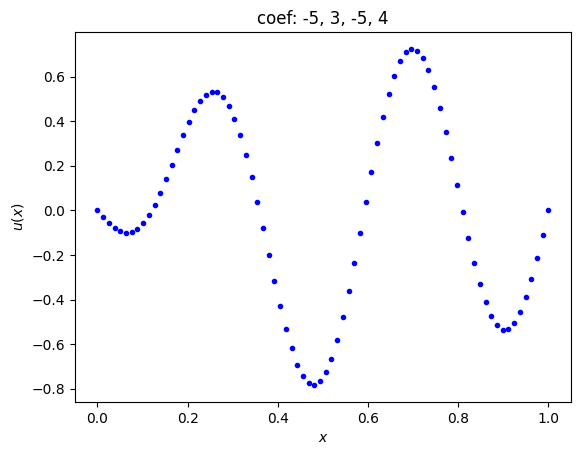

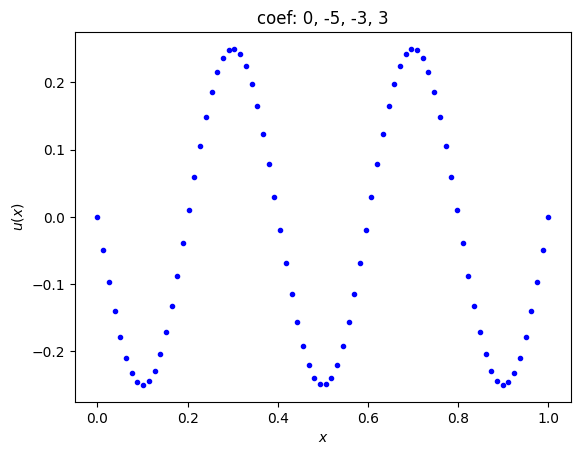

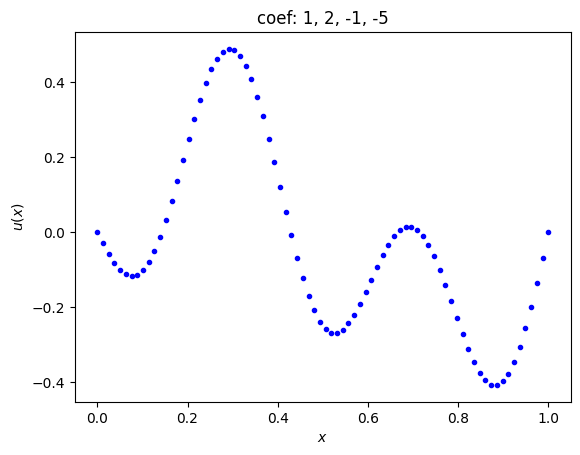

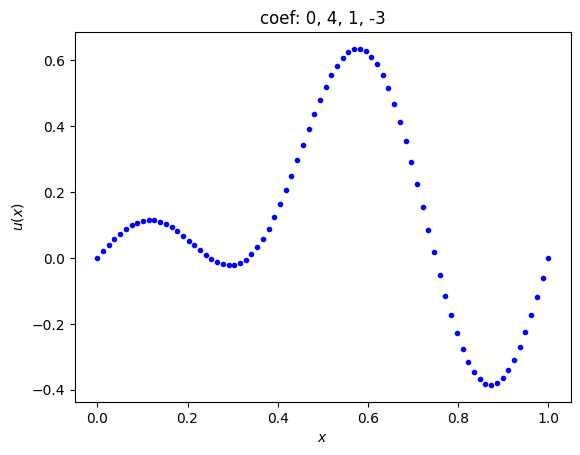

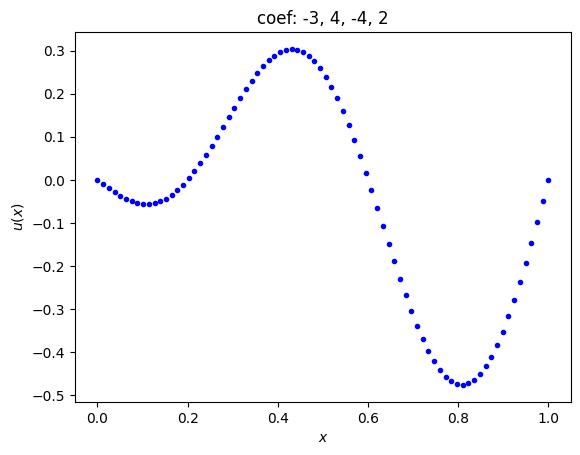

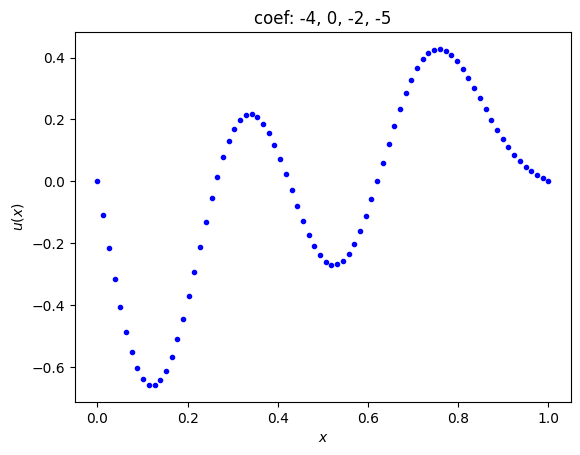

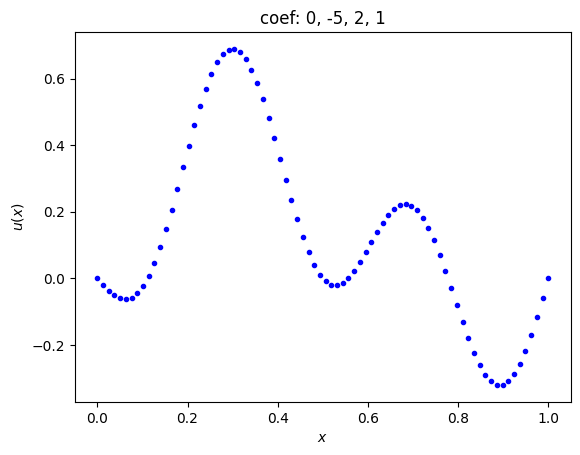

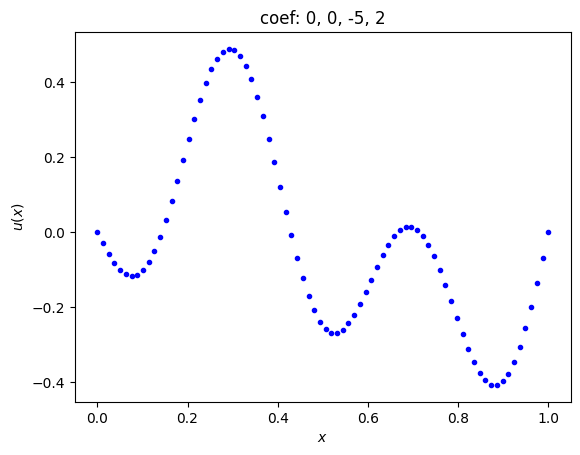

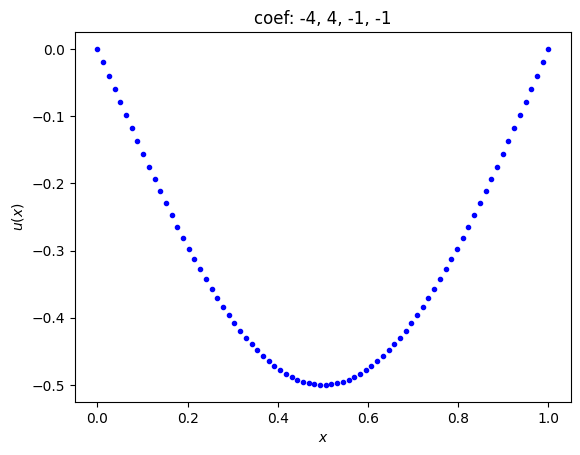

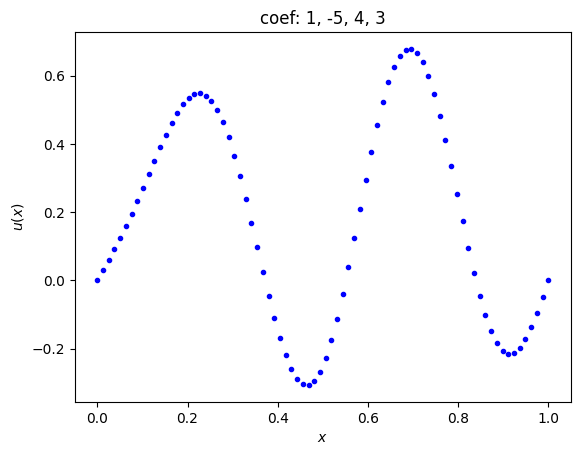

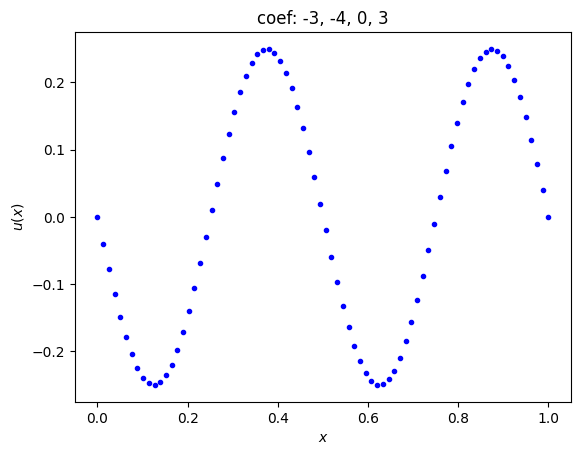

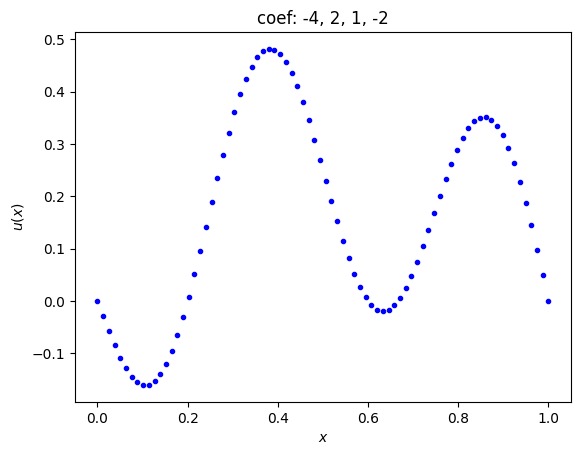

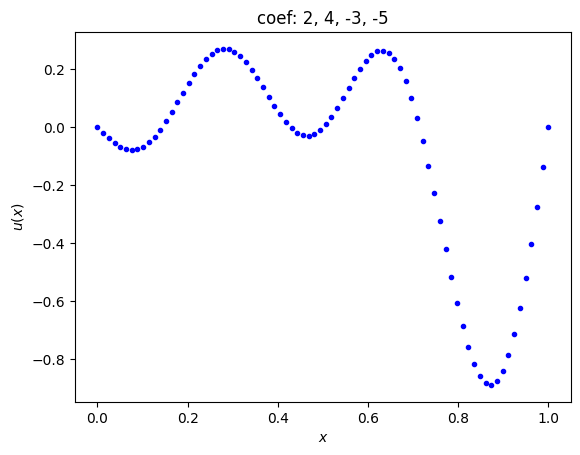

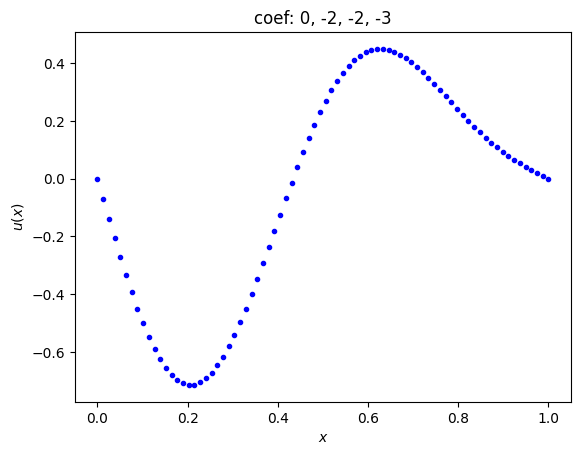

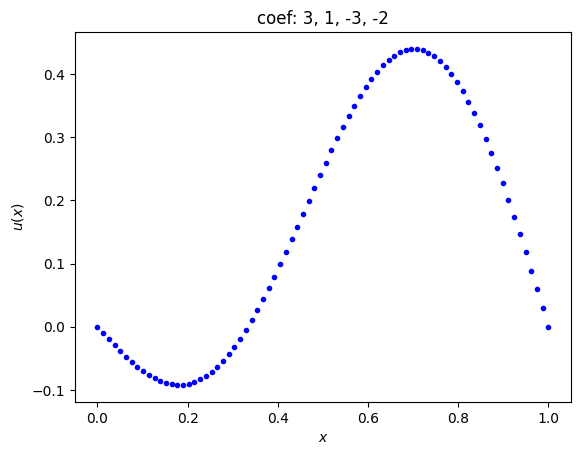

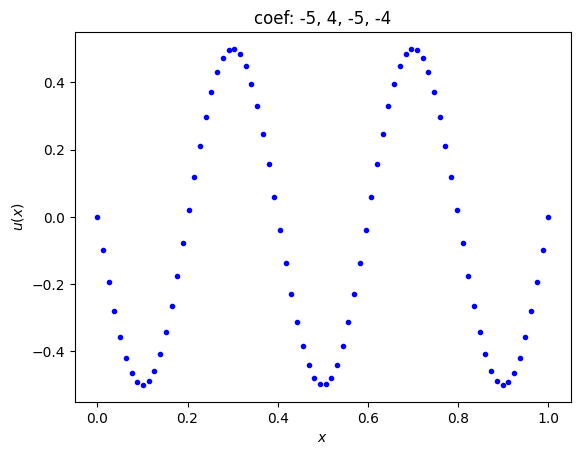

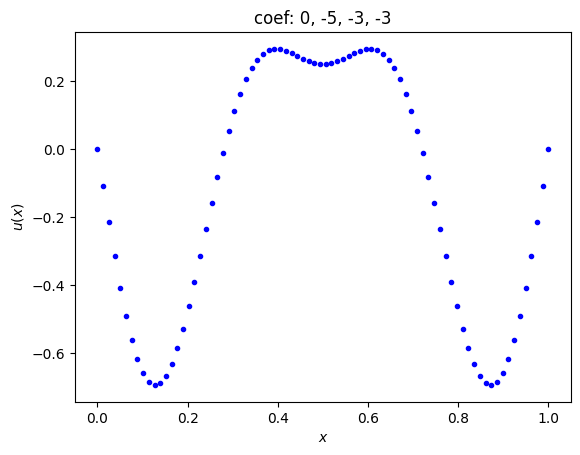

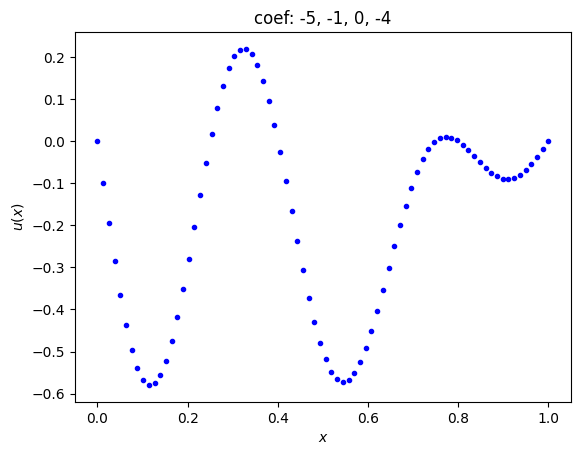

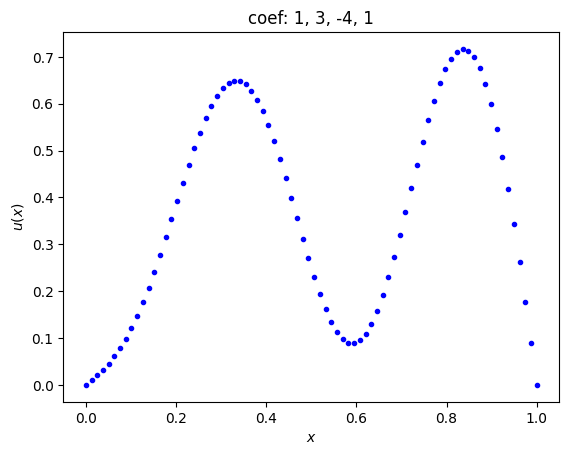

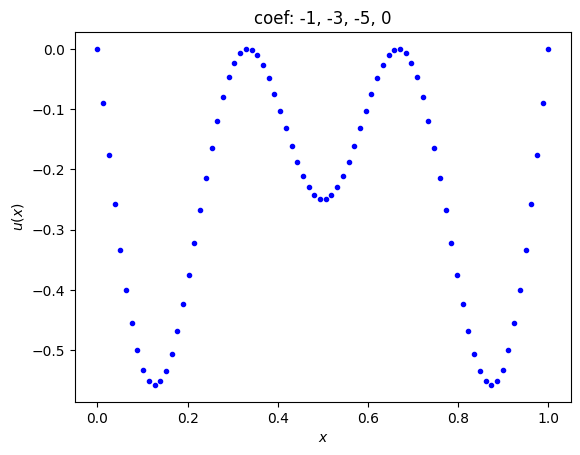

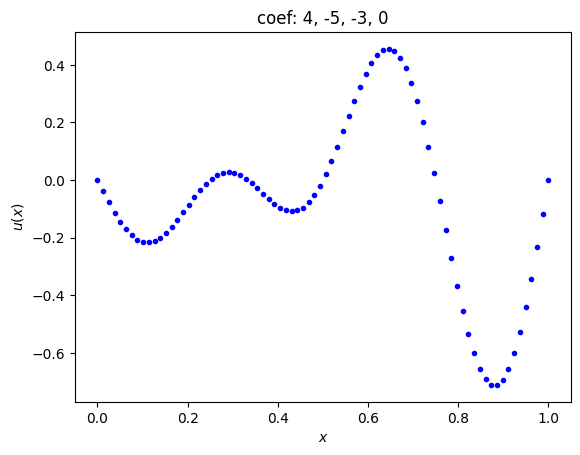

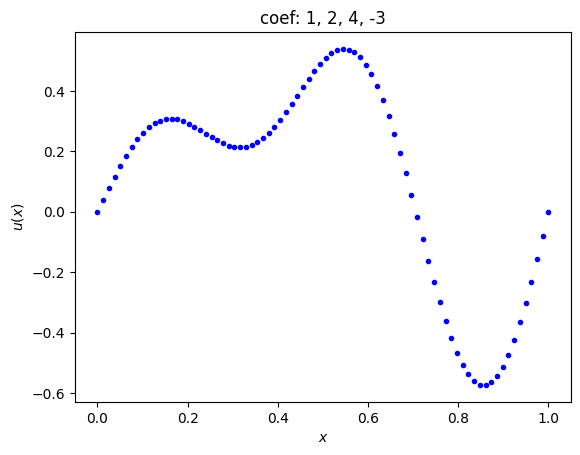

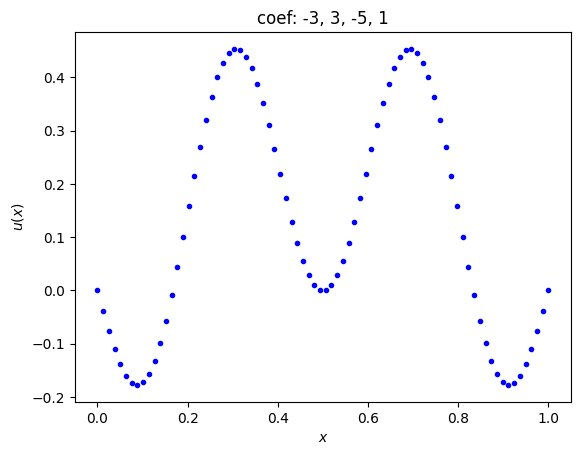

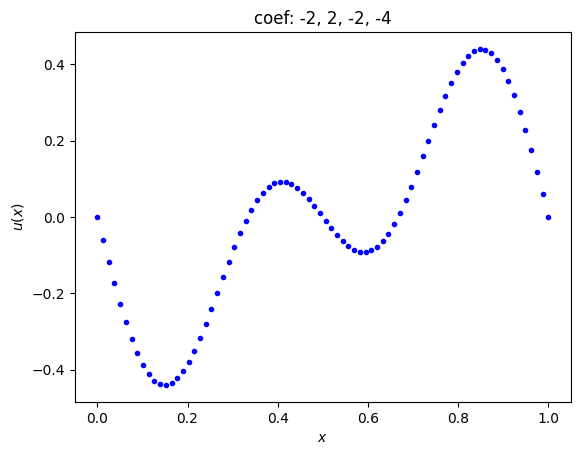

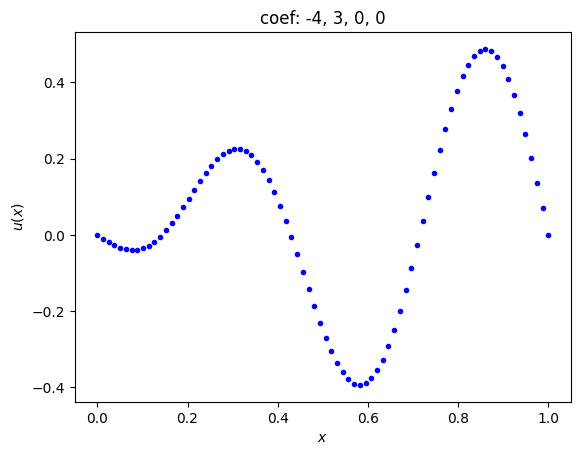

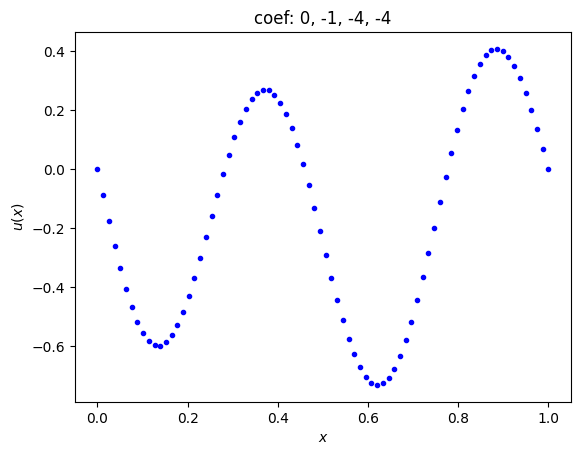

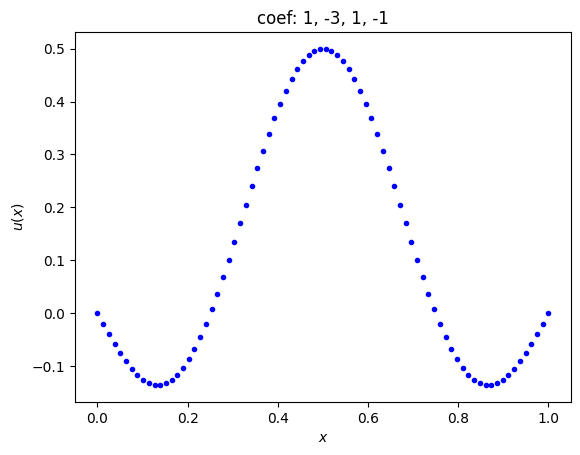

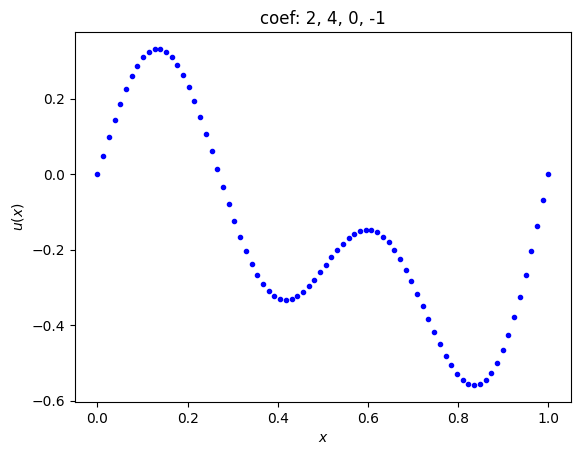

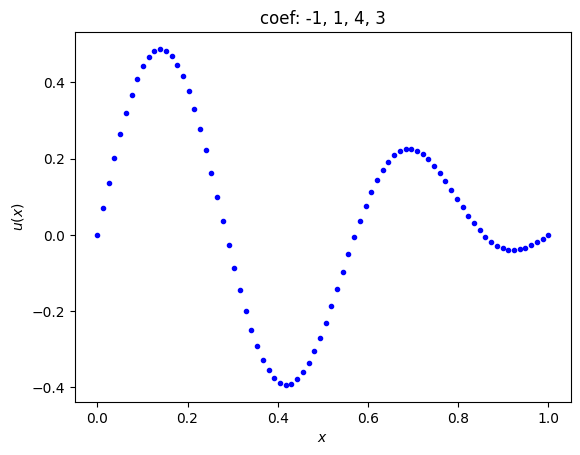

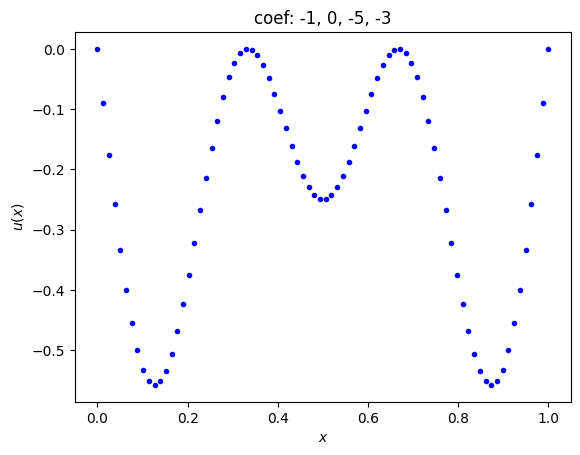

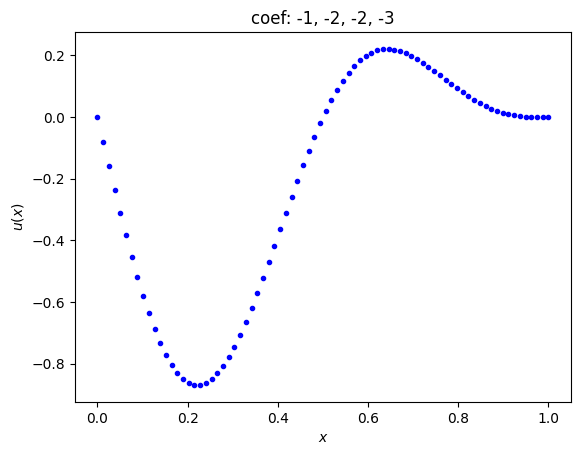

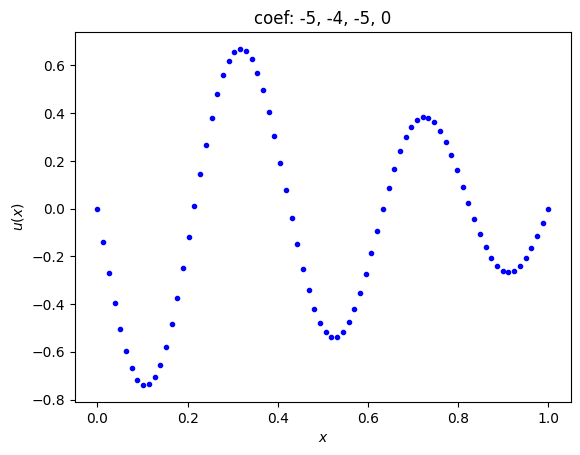

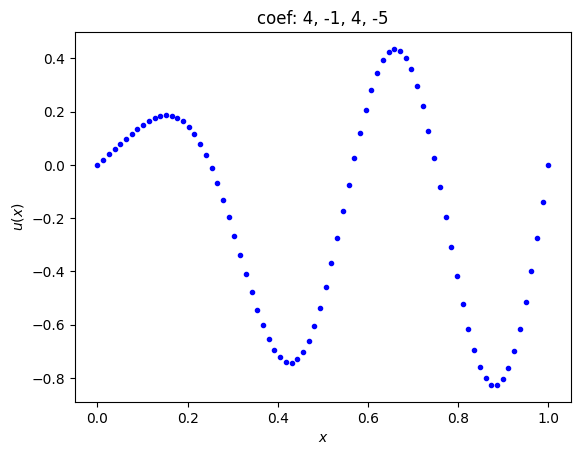

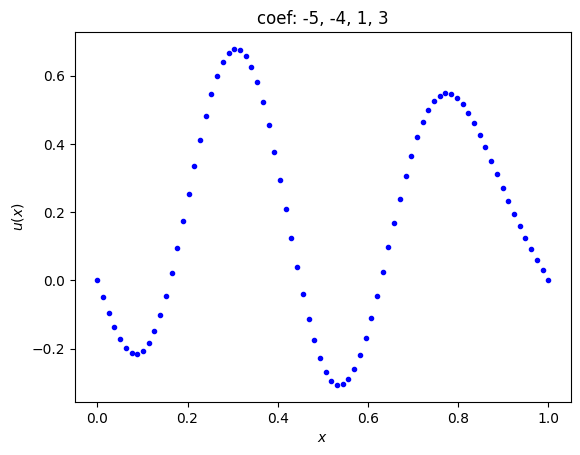

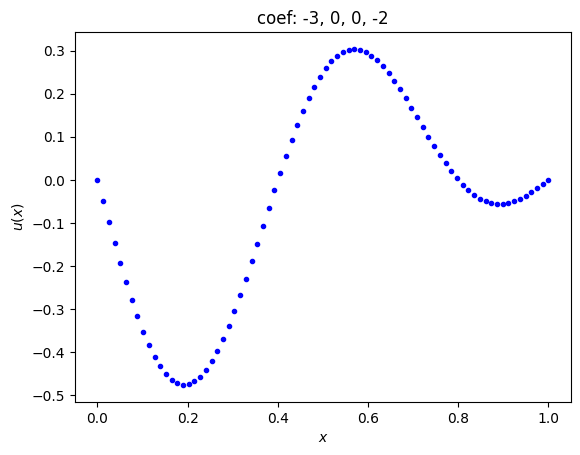

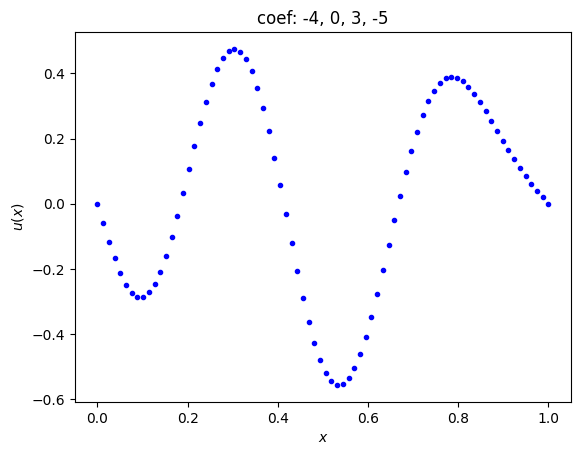

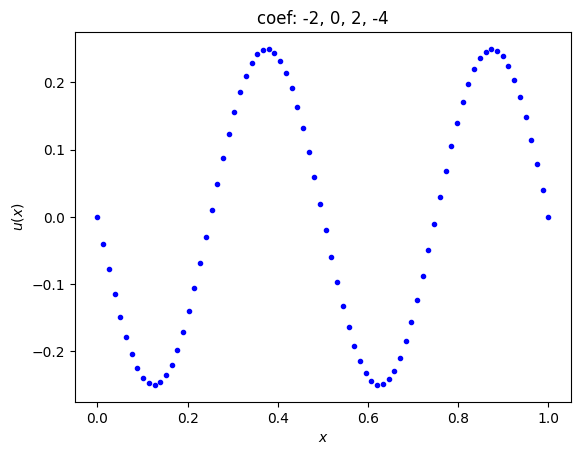

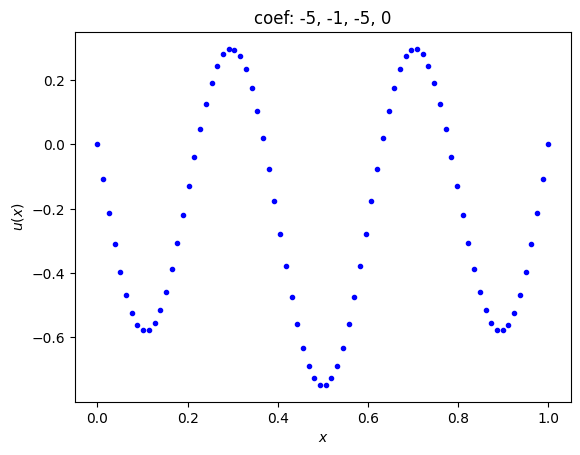

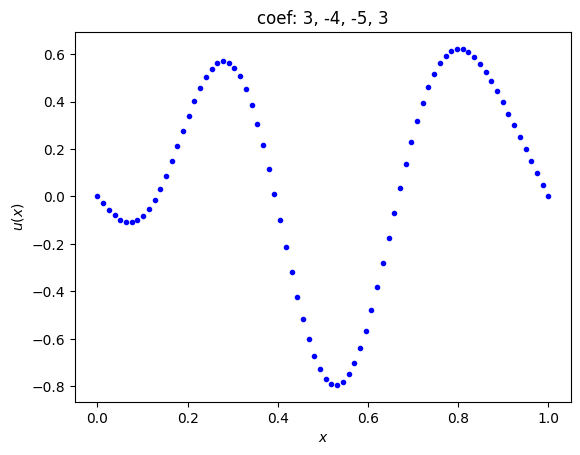

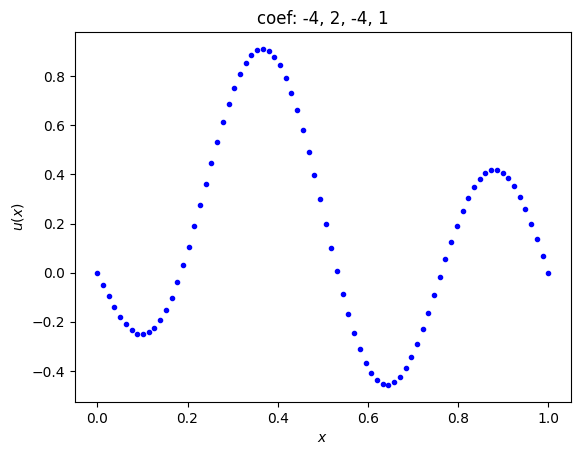

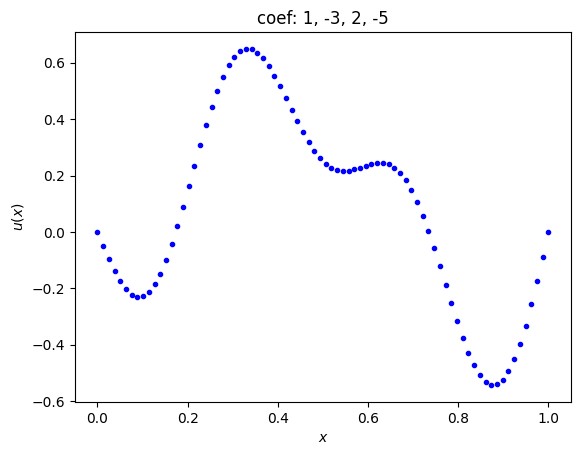

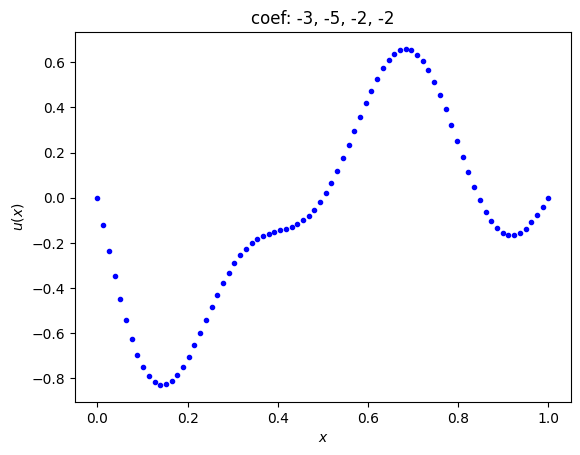

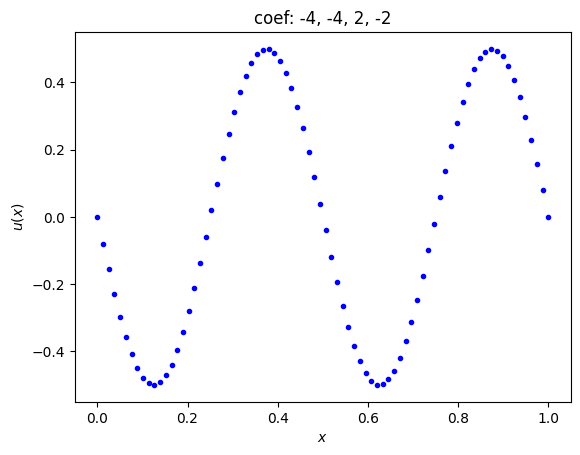

In [ ]:
for i in range(0, 100):
  plt.scatter(X_sample, u_sample[f'{i}'],marker=".", color='b', label='Data points')
  a_1 = coef[f'{i}'][0]
  a_2 = coef[f'{i}'][1]
  a_3 = coef[f'{i}'][2]
  a_4 = coef[f'{i}'][3]
  plt.title(f'coef: {a_1}, {a_2}, {a_3}, {a_4}')
  plt.xlabel('$x$')
  plt.ylabel('$u(x)$')
  plt.show()

## Generating the whole dataset

In [ ]:
def generate_dataset(u_sample_num, sensors, P_t=30,):
  # getting the u samples needed
  u_samples, coef = crate_samples_cos(u_sample_num=u_sample_num, sensors=sensors)

  # The location X of the sensors (same points the function s(t,x) will be avaluated in the space domain)
  X_sample = np.linspace(0, 1, sensors)
  X_sample_colo = X_sample[1:sensors - 1] # sample for colocation points w/o boundary condition points

  # The location of the points in t where the boundary conditions error and the resudual of the PDE will be calculated
  T_sample = np.linspace(0, 0.03, P_t)
  T_sample_colo = T_sample[1:] # sample for colocation points w/o initial condition points

  # data for the inital condition of the PDE
  IC_x = []
  IC_u = []
  IC_s = []
  Data_IC = [IC_x, IC_u, IC_s]

  BC_x = []
  BC_u = []
  BC_s = []
  Data_BC = [BC_x, BC_u, BC_s]

  Colo_x = []
  Colo_u = []
  Data_Colocation = [Colo_x, Colo_u]

  for i in range(0, u_sample_num):
    for j in range(0, sensors):
      Data_IC[0].append([float(0), float(X_sample[j])])
      Data_IC[1].append(u_samples[f'{i}'])
      Data_IC[2].append(u_samples[f'{i}'][j])


    for j in range(0, P_t):
      Data_BC[0].append([float(T_sample[j]), float(0)])
      Data_BC[1].append(u_samples[f'{i}'])
      Data_BC[2].append(float(0))

    for j in range(0, P_t):
      Data_BC[0].append([float(T_sample[j]), float(1)])
      Data_BC[1].append((u_samples[f'{i}']))
      Data_BC[2].append(float(0))

    for j in range(0, P_t - 1):
      for k in range(0, sensors - 2):
        Data_Colocation[0].append([T_sample_colo[j], X_sample_colo[k]])
        Data_Colocation[1].append(u_samples[f'{i}'])


  Data_IC[0] = tf.convert_to_tensor(Data_IC[0], dtype=tf.float32)
  Data_IC[1] = tf.convert_to_tensor(Data_IC[1], dtype=tf.float32)
  Data_IC[2] = tf.convert_to_tensor(Data_IC[2], dtype=tf.float32)
  Data_IC[2] = tf.reshape(Data_IC[2], [sensors * u_sample_num, 1])

  Data_BC[0] = tf.convert_to_tensor(Data_BC[0], dtype=tf.float32)
  Data_BC[1] = tf.convert_to_tensor(Data_BC[1], dtype=tf.float32)
  Data_BC[2] = tf.convert_to_tensor(Data_BC[2], dtype=tf.float32)
  Data_BC[2] = tf.reshape(Data_BC[2], [P_t * 2 * u_sample_num, 1])

  Data_Colocation[0] = tf.convert_to_tensor(Data_Colocation[0], dtype=tf.float32)
  Data_Colocation[1] = tf.convert_to_tensor(Data_Colocation[1], dtype=tf.float32)


  return Data_IC, Data_BC, Data_Colocation, coef

# Do later: Remove from colocation points the points from boundary and initial conditions DONE!

In [ ]:
Data_IC, Data_BC, Data_Colocation, coef = generate_dataset(u_sample_num=100, sensors=sensors)

In [ ]:
coef

{'0': [-1, -3, -3, -3],
 '1': [-1, -5, 3, 1],
 '2': [4, 1, 2, 4],
 '3': [3, 2, -5, 3],
 '4': [-4, 4, -1, 0],
 '5': [-3, -2, 4, 2],
 '6': [3, -4, -5, -4],
 '7': [-4, -1, 1, 3],
 '8': [-2, 0, 1, 1],
 '9': [2, -3, -3, 0],
 '10': [3, -5, -5, 3],
 '11': [-4, -2, -4, -5],
 '12': [-1, -5, -5, 3],
 '13': [-2, -5, 3, -1],
 '14': [-5, -4, 0, 3],
 '15': [2, -1, 4, 3],
 '16': [0, -3, -5, 4],
 '17': [0, -3, -1, 3],
 '18': [4, 4, 4, -3],
 '19': [-2, 1, 0, 1],
 '20': [-3, 4, 4, 4],
 '21': [-4, 4, 3, 0],
 '22': [4, -3, -3, 2],
 '23': [-3, -1, 3, -2],
 '24': [1, 3, -4, 4],
 '25': [-5, 0, -1, 1],
 '26': [-5, -3, -2, -3],
 '27': [-2, 3, -3, 3],
 '28': [0, -3, 1, 3],
 '29': [-3, -2, -4, 4],
 '30': [-4, 1, 4, 3],
 '31': [-4, -5, -4, -5],
 '32': [0, 3, -4, -5],
 '33': [4, -4, -5, -4],
 '34': [4, -4, -2, -5],
 '35': [-4, 2, 2, 3],
 '36': [4, -3, -4, 0],
 '37': [3, 1, -4, 0],
 '38': [-4, 3, -4, 1],
 '39': [0, -1, 3, -3],
 '40': [-3, -5, 0, 3],
 '41': [4, 0, -2, 3],
 '42': [2, 0, -3, 2],
 '43': [-3, -5, -2, 4]

## Salvando dados de treino

In [ ]:
with open(root_path + 'Data_IC_v3', 'wb') as fp:
  pickle.dump(Data_IC, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(root_path + 'Data_BC_v3', 'wb') as fp:
  pickle.dump(Data_BC, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(root_path + 'Data_Colocation_v3', 'wb') as fp:
  pickle.dump(Data_Colocation, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Plotting the points


In [ ]:
Data_Colocation

[<tf.Tensor: shape=(226200, 2), dtype=float32, numpy=
 array([[0.00862069, 0.01265823],
        [0.00862069, 0.02531646],
        [0.00862069, 0.03797468],
        ...,
        [0.25      , 0.96202534],
        [0.25      , 0.9746835 ],
        [0.25      , 0.98734176]], dtype=float32)>,
 <tf.Tensor: shape=(226200, 80), dtype=float32, numpy=
 array([[ 1.        ,  0.9839928 ,  0.9366385 , ...,  0.68696046,
          0.60587186,  0.50402033],
        [ 1.        ,  0.9839928 ,  0.9366385 , ...,  0.68696046,
          0.60587186,  0.50402033],
        [ 1.        ,  0.9839928 ,  0.9366385 , ...,  0.68696046,
          0.60587186,  0.50402033],
        ...,
        [ 1.        ,  0.9763906 ,  0.9075174 , ..., -0.32804492,
         -0.23173067, -0.11987049],
        [ 1.        ,  0.9763906 ,  0.9075174 , ..., -0.32804492,
         -0.23173067, -0.11987049],
        [ 1.        ,  0.9763906 ,  0.9075174 , ..., -0.32804492,
         -0.23173067, -0.11987049]], dtype=float32)>]

In [ ]:
Data_IC[2][sensors:sensors*2]

<tf.Tensor: shape=(80, 1), dtype=float32, numpy=
array([[ 1.        ],
       [ 0.93620163],
       [ 0.76134324],
       [ 0.52011913],
       [ 0.27217647],
       [ 0.07474943],
       [-0.03347891],
       [-0.04236336],
       [ 0.02876262],
       [ 0.13916503],
       [ 0.24091561],
       [ 0.2944598 ],
       [ 0.28048635],
       [ 0.2044021 ],
       [ 0.09226194],
       [-0.02011809],
       [-0.10089043],
       [-0.1338955 ],
       [-0.1242901 ],
       [-0.09615452],
       [-0.0829469 ],
       [-0.11417454],
       [-0.20300837],
       [-0.3393158 ],
       [-0.49080122],
       [-0.6122116 ],
       [-0.65979636],
       [-0.6063339 ],
       [-0.4516943 ],
       [-0.22523345],
       [ 0.0211063 ],
       [ 0.2271114 ],
       [ 0.341709  ],
       [ 0.3380771 ],
       [ 0.22170433],
       [ 0.02883067],
       [-0.18428558],
       [-0.35795015],
       [-0.44632468],
       [-0.4301157 ],
       [-0.32086793],
       [-0.15577812],
       [ 0.01503742],
     

In [ ]:
Data_IC[2][1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9839928], dtype=float32)>

In [ ]:
i = 97
Initial_condition_U_ex =  Data_IC[2][sensors*i:sensors*(i+1)]
Initial_condition_tx_ex =  Data_IC[0][sensors*i:sensors*(i+1)]
Boundary_condition_U_ex = Data_BC[2]
Boundary_condition_tx_ex = Data_BC[0]
Colocation_tx_ex = Data_Colocation[0][0:(30-1)*(sensors-2)]

Text(0.5, 1.0, 'Intial Condition')

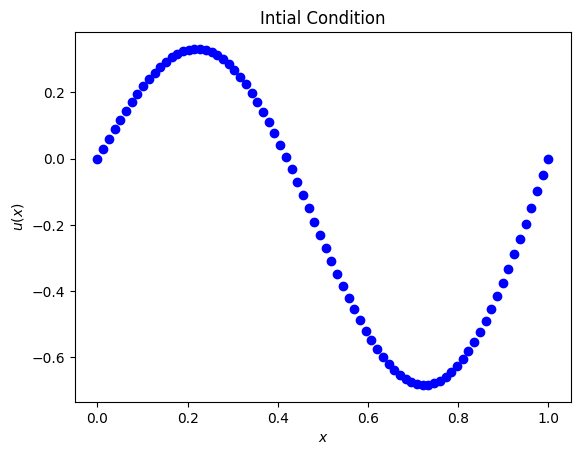

In [ ]:
plt.scatter(Initial_condition_tx_ex[:,1], Initial_condition_U_ex, color='b', label='Data points')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('Intial Condition')

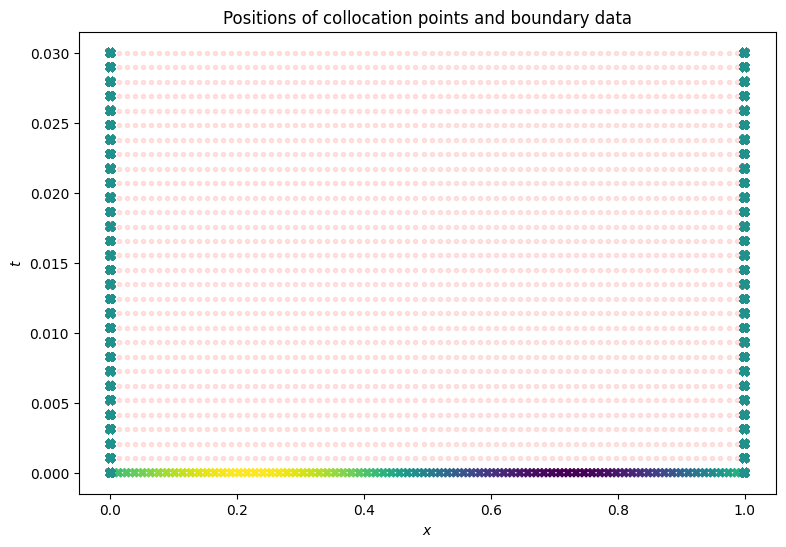

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(Initial_condition_tx_ex[:,1], Initial_condition_tx_ex[:,0], c=Initial_condition_U_ex, marker='X')
plt.scatter(Boundary_condition_tx_ex[:,1], Boundary_condition_tx_ex[:,0], c=Boundary_condition_U_ex, marker='X', vmin=-1, vmax=1)
plt.scatter(Colocation_tx_ex[:,1], Colocation_tx_ex[:,0], c='r', marker='.', alpha=0.1)
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Positions of collocation points and boundary data');
plt.show()

### Rascunho

In [ ]:
s_pred_IC = PI_DeepONet([Data_IC[1], Data_IC[0]])

In [ ]:
Data_IC

[<tf.Tensor: shape=(6000, 2), dtype=float32, numpy=
 array([[0.        , 0.        ],
        [0.        , 0.01694915],
        [0.        , 0.03389831],
        ...,
        [0.        , 0.9661017 ],
        [0.        , 0.9830508 ],
        [0.        , 1.        ]], dtype=float32)>,
 <tf.Tensor: shape=(6000, 80), dtype=float32, numpy=
 array([[ 1.        ,  0.9023303 ,  0.63749766, ...,  0.23821546,
          0.07840443, -0.08860651],
        [ 1.        ,  0.9023303 ,  0.63749766, ...,  0.23821546,
          0.07840443, -0.08860651],
        [ 1.        ,  0.9023303 ,  0.63749766, ...,  0.23821546,
          0.07840443, -0.08860651],
        ...,
        [ 1.        ,  0.92998624,  0.7369154 , ...,  0.2899035 ,
          0.19492824,  0.0478921 ],
        [ 1.        ,  0.92998624,  0.7369154 , ...,  0.2899035 ,
          0.19492824,  0.0478921 ],
        [ 1.        ,  0.92998624,  0.7369154 , ...,  0.2899035 ,
          0.19492824,  0.0478921 ]], dtype=float32)>,
 <tf.Tensor: shap

In [ ]:
Data_IC[2][4]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1450998], dtype=float32)>

In [ ]:
s_pred_IC - Data_IC[2]

<tf.Tensor: shape=(6000, 1), dtype=float32, numpy=
array([[-0.98405606],
       [-0.8501019 ],
       [-0.50753474],
       ...,
       [ 0.28701118],
       [ 0.22415438],
       [ 0.05881011]], dtype=float32)>

In [ ]:
Data_IC[2]

<tf.Tensor: shape=(6000, 1), dtype=float32, numpy=
array([[ 1.        ],
       [ 0.863856  ],
       [ 0.51911485],
       ...,
       [-0.14975421],
       [-0.09316932],
       [ 0.06574816]], dtype=float32)>

In [ ]:
tf.reduce_mean(keras.losses.mean_squared_error(s_pred_IC, Data_IC[2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.13947585>

# Model and traning functions

## Model functions

In [ ]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer

@register_keras_serializable()
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

In [ ]:
def create_model(verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net input
    branch_input = tf.keras.Input(shape=sensors)
    #branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)

    branch = tf.keras.layers.Dense(50, activation="tanh")(branch_input)
    branch = tf.keras.layers.Dense(50, activation="tanh")(branch)
    branch = tf.keras.layers.Dense(20, activation="tanh")(branch)

    # Trunk net input
    trunk_input = tf.keras.Input(shape=2)
    #trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)

    trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk_input)
    trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)
    trunk = tf.keras.layers.Dense(20, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

In [ ]:
model = create_model(verbose=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 50)                   4050      ['input_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 50)                   150       ['input_2[0][0]']             
                                                                                              

## Residual calculator function

In [ ]:
@tf.function
def PDE_residual_calculator(Data_Colocation, model):

    with tf.GradientTape(persistent=True) as tape:

      t = Data_Colocation[0][:,0]
      x = Data_Colocation[0][:,1]

      tape.watch(t)
      tape.watch(x)

      s = model([Data_Colocation[1], tf.stack([t, x], axis=1)])

      # Calculate gradients
      s_x = tape.gradient(s, x)

    s_t = tape.gradient(s, t)
    s_xx = tape.gradient(s_x, x)

    del tape

    # ODE residual
    ODE_residual = s_t - 1*s_xx

    return ODE_residual

## Training function

In [ ]:
@tf.function
def get_grad(model, Data_IC, Data_BC, Data_Colocation, IC_BC_weight=1, PDE_weight=1):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)

        # Initial condition prediction
        s_pred_IC = model([Data_IC[1], Data_IC[0]])
        s_pred_BC = model([Data_BC[1], Data_BC[0]])

        # Equation residual
        ODE_residual = PDE_residual_calculator(Data_Colocation, model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(Data_IC[2], s_pred_IC))
        BC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, s_pred_BC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))


        # Total loss
        total_loss = IC_loss*8 + BC_loss + ODE_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)

    del tape

    return ODE_loss, IC_loss, BC_loss, total_loss, gradients

# Loading data, loss hist and model

In [ ]:
PI_DeepONet = load_model(root_path + 'PI_DeepONet_v2.h5' , custom_objects={'BiasLayer': BiasLayer})
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
optimizer.build(PI_DeepONet.trainable_variables)
PI_DeepONet.compile(optimizer=optimizer)

In [ ]:
with open(root_path + 'Data_IC_v2', 'rb') as fp:
    Data_IC = pickle.load(fp)

with open(root_path + 'Data_BC_v2', 'rb') as fp:
    Data_BC = pickle.load(fp)

with open(root_path + 'Data_Colocation_v2', 'rb') as fp:
    Data_Colocation = pickle.load(fp)

In [ ]:
with open(root_path + 'total_loss_hist_v2.p', 'rb') as fp:
    total_loss_hist = pickle.load(fp)

with open(root_path + 'ODE_loss_hist_v2.p', 'rb') as fp:
    ODE_loss_hist = pickle.load(fp)

with open(root_path + 'IC_loss_hist_v2.p', 'rb') as fp:
    IC_loss_hist = pickle.load(fp)

with open(root_path + 'BC_loss_hist_v2.p', 'rb') as fp:
    BC_loss_hist = pickle.load(fp)

## Teste loaded model

In [ ]:
len(total_loss_hist)

35506

In [ ]:
IC_loss_hist[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.00010412027>

In [ ]:
ODE_loss, IC_loss, BC_loss, total_loss, gradients = get_grad(PI_DeepONet, Data_IC, Data_BC, Data_Colocation)

In [ ]:
print('IC loss = {:10.6e}; BC loss = {:10.6e}; PDE loss = {:10.6e} Total loss = {:10.8e}'
    .format(IC_loss, BC_loss, ODE_loss, total_loss))

IC loss = 1.014181e-04; BC loss = 3.808626e-04; PDE loss = 1.811320e-03 Total loss = 3.00352718e-03


## Initialization of model and loss hist (If needed)

In [ ]:
# Instantiate the PINN model
PI_DeepONet= create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
PI_DeepONet.compile(optimizer=optimizer)


total_loss_hist = []
ODE_loss_hist = []
IC_loss_hist = []
BC_loss_hist = []

# Training

In [ ]:
from time import time

In [ ]:
# v2 - 7
@tf.function
def train_step(model, Data_IC, Data_BC, Data_Colocation):
    # Compute current loss and gradient w.r.t. parameters
    ODE_loss, IC_loss, BC_loss, total_loss, gradients = get_grad(model, Data_IC, Data_BC, Data_Colocation)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))

    return ODE_loss, IC_loss, BC_loss, total_loss


N = 10000

# Start timer
t0 = time()



for i in range(N+1):

  ODE_loss, IC_loss, BC_loss, total_loss = train_step(PI_DeepONet, Data_IC, Data_BC, Data_Colocation)

  # Append current loss to hist
  total_loss_hist.append(total_loss)
  ODE_loss_hist.append(ODE_loss)
  IC_loss_hist.append(IC_loss)
  BC_loss_hist.append(BC_loss)

  # Output current loss after 50 iterates
  if i%10 == 0:
    print('It {:05d}: IC loss = {:10.6e}; BC loss = {:10.6e}; PDE loss = {:10.6e} Total loss = {:10.8e}'
    .format(i, IC_loss, BC_loss, ODE_loss, total_loss))

  if i%100 == 0:
    PI_DeepONet.save(root_path + 'PI_DeepONet_v2.h5')
    with open(root_path + 'total_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(total_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'ODE_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(ODE_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'IC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(IC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'BC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(BC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: IC loss = 1.014181e-04; BC loss = 3.808626e-04; PDE loss = 1.811320e-03 Total loss = 3.00352741e-03


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


It 00010: IC loss = 1.415629e-02; BC loss = 1.812226e-03; PDE loss = 1.060527e-01 Total loss = 2.21115232e-01
It 00020: IC loss = 8.023641e-03; BC loss = 2.416854e-03; PDE loss = 3.217248e-02 Total loss = 9.87784714e-02
It 00030: IC loss = 5.110930e-03; BC loss = 1.728022e-03; PDE loss = 2.013197e-02 Total loss = 6.27474263e-02
It 00040: IC loss = 2.849449e-03; BC loss = 2.377642e-03; PDE loss = 1.158666e-02 Total loss = 3.67598906e-02
It 00050: IC loss = 1.405530e-03; BC loss = 1.554384e-03; PDE loss = 7.350031e-03 Total loss = 2.01486573e-02
It 00060: IC loss = 7.054289e-04; BC loss = 9.488359e-04; PDE loss = 4.967512e-03 Total loss = 1.15597788e-02
It 00070: IC loss = 3.748172e-04; BC loss = 5.422650e-04; PDE loss = 3.442476e-03 Total loss = 6.98327832e-03
It 00080: IC loss = 2.332098e-04; BC loss = 4.518665e-04; PDE loss = 2.510259e-03 Total loss = 4.82780393e-03
It 00090: IC loss = 1.728800e-04; BC loss = 4.353694e-04; PDE loss = 2.110995e-03 Total loss = 3.92940454e-03
It 00100: 

In [ ]:
# v2 - 6
@tf.function
def train_step(model, Data_IC, Data_BC, Data_Colocation):
    # Compute current loss and gradient w.r.t. parameters
    ODE_loss, IC_loss, BC_loss, total_loss, gradients = get_grad(model, Data_IC, Data_BC, Data_Colocation)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))

    return ODE_loss, IC_loss, BC_loss, total_loss


N = 50000

# Start timer
t0 = time()



for i in range(N+1):

  ODE_loss, IC_loss, BC_loss, total_loss = train_step(PI_DeepONet, Data_IC, Data_BC, Data_Colocation)

  # Append current loss to hist
  total_loss_hist.append(total_loss)
  ODE_loss_hist.append(ODE_loss)
  IC_loss_hist.append(IC_loss)
  BC_loss_hist.append(BC_loss)

  # Output current loss after 50 iterates
  if i%10 == 0:
    print('It {:05d}: IC loss = {:10.6e}; BC loss = {:10.6e}; PDE loss = {:10.6e} Total loss = {:10.8e}'
    .format(i, IC_loss, BC_loss, ODE_loss, total_loss))

  if i%100 == 0:
    PI_DeepONet.save(root_path + 'PI_DeepONet_v2.h5')
    with open(root_path + 'total_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(total_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'ODE_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(ODE_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'IC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(IC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'BC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(BC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: IC loss = 1.280952e-04; BC loss = 4.804033e-04; PDE loss = 1.980881e-03 Total loss = 3.48604517e-03


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


It 00010: IC loss = 1.577076e-02; BC loss = 3.671812e-03; PDE loss = 1.293810e-01 Total loss = 2.59218872e-01
It 00020: IC loss = 8.678121e-03; BC loss = 2.605812e-03; PDE loss = 3.163346e-02 Total loss = 1.03664234e-01
It 00030: IC loss = 4.478362e-03; BC loss = 1.522854e-03; PDE loss = 2.699562e-02 Total loss = 6.43453747e-02
It 00040: IC loss = 2.132835e-03; BC loss = 1.689984e-03; PDE loss = 1.151307e-02 Total loss = 3.02657411e-02
It 00050: IC loss = 8.613284e-04; BC loss = 1.733859e-03; PDE loss = 8.472471e-03 Total loss = 1.70969553e-02
It 00060: IC loss = 3.961659e-04; BC loss = 1.443430e-03; PDE loss = 4.671941e-03 Total loss = 9.28469747e-03
It 00070: IC loss = 2.864163e-04; BC loss = 9.967862e-04; PDE loss = 3.291819e-03 Total loss = 6.57993509e-03
It 00080: IC loss = 2.163845e-04; BC loss = 6.878007e-04; PDE loss = 2.692362e-03 Total loss = 5.11123799e-03
It 00090: IC loss = 1.908539e-04; BC loss = 5.682848e-04; PDE loss = 2.313586e-03 Total loss = 4.40870272e-03
It 00100: 

KeyboardInterrupt: 

In [ ]:
# v2 - 5
@tf.function
def train_step(model, Data_IC, Data_BC, Data_Colocation):
    # Compute current loss and gradient w.r.t. parameters
    ODE_loss, IC_loss, BC_loss, total_loss, gradients = get_grad(model, Data_IC, Data_BC, Data_Colocation)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))

    return ODE_loss, IC_loss, BC_loss, total_loss


N = 50000

# Start timer
t0 = time()



for i in range(N+1):

  ODE_loss, IC_loss, BC_loss, total_loss = train_step(PI_DeepONet, Data_IC, Data_BC, Data_Colocation)

  # Append current loss to hist
  total_loss_hist.append(total_loss)
  ODE_loss_hist.append(ODE_loss)
  IC_loss_hist.append(IC_loss)
  BC_loss_hist.append(BC_loss)

  # Output current loss after 50 iterates
  if i%10 == 0:
    print('It {:05d}: IC loss = {:10.6e}; BC loss = {:10.6e}; PDE loss = {:10.6e} Total loss = {:10.8e}'
    .format(i, IC_loss, BC_loss, ODE_loss, total_loss))

  if i%100 == 0:
    PI_DeepONet.save(root_path + 'PI_DeepONet_v2.h5')
    with open(root_path + 'total_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(total_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'ODE_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(ODE_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'IC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(IC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'BC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(BC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: IC loss = 2.287493e-04; BC loss = 7.142057e-04; PDE loss = 3.723834e-03 Total loss = 6.26803329e-03


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


It 00010: IC loss = 2.144594e-02; BC loss = 1.751268e-03; PDE loss = 1.581168e-01 Total loss = 3.31435621e-01
It 00020: IC loss = 1.227323e-02; BC loss = 2.484264e-03; PDE loss = 4.766928e-02 Total loss = 1.48339391e-01
It 00030: IC loss = 6.574871e-03; BC loss = 3.120463e-03; PDE loss = 2.966424e-02 Total loss = 8.53836685e-02
It 00040: IC loss = 3.725708e-03; BC loss = 2.046321e-03; PDE loss = 2.003457e-02 Total loss = 5.18865511e-02
It 00050: IC loss = 2.065235e-03; BC loss = 2.175724e-03; PDE loss = 1.543806e-02 Total loss = 3.41356620e-02
It 00060: IC loss = 1.220549e-03; BC loss = 1.897755e-03; PDE loss = 9.554456e-03 Total loss = 2.12166011e-02
It 00070: IC loss = 7.065600e-04; BC loss = 1.464965e-03; PDE loss = 7.270288e-03 Total loss = 1.43877333e-02
It 00080: IC loss = 5.070802e-04; BC loss = 1.095985e-03; PDE loss = 5.208565e-03 Total loss = 1.03611918e-02
It 00090: IC loss = 3.750646e-04; BC loss = 9.101090e-04; PDE loss = 4.082056e-03 Total loss = 7.99268112e-03
It 00100: 

In [ ]:
# v2 - 4
@tf.function
def train_step(model, Data_IC, Data_BC, Data_Colocation):
    # Compute current loss and gradient w.r.t. parameters
    ODE_loss, IC_loss, BC_loss, total_loss, gradients = get_grad(model, Data_IC, Data_BC, Data_Colocation)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))

    return ODE_loss, IC_loss, BC_loss, total_loss


N = 50000

# Start timer
t0 = time()



for i in range(N+1):

  ODE_loss, IC_loss, BC_loss, total_loss = train_step(PI_DeepONet, Data_IC, Data_BC, Data_Colocation)

  # Append current loss to hist
  total_loss_hist.append(total_loss)
  ODE_loss_hist.append(ODE_loss)
  IC_loss_hist.append(IC_loss)
  BC_loss_hist.append(BC_loss)

  # Output current loss after 50 iterates
  if i%10 == 0:
    print('It {:05d}: IC loss = {:10.6e}; BC loss = {:10.6e}; PDE loss = {:10.6e} Total loss = {:10.8e}'
    .format(i, IC_loss, BC_loss, ODE_loss, total_loss))

  if i%100 == 0:
    PI_DeepONet.save(root_path + 'PI_DeepONet_v2.h5')
    with open(root_path + 'total_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(total_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'ODE_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(ODE_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'IC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(IC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(root_path + 'BC_loss_hist_v2.p', 'wb') as fp:
      pickle.dump(BC_loss_hist, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: IC loss = 5.519281e-04; BC loss = 1.201467e-03; PDE loss = 4.186685e-03 Total loss = 9.80357639e-03


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


It 00010: IC loss = 1.079372e-02; BC loss = 5.025913e-03; PDE loss = 1.948284e-01 Total loss = 2.86204070e-01
It 00020: IC loss = 1.274823e-02; BC loss = 3.990791e-03; PDE loss = 5.034968e-02 Total loss = 1.56326279e-01
It 00030: IC loss = 7.970343e-03; BC loss = 3.431813e-03; PDE loss = 3.053747e-02 Total loss = 9.77320224e-02
It 00040: IC loss = 4.804081e-03; BC loss = 2.642967e-03; PDE loss = 2.747915e-02 Total loss = 6.85547590e-02
It 00050: IC loss = 2.816880e-03; BC loss = 2.694556e-03; PDE loss = 1.923644e-02 Total loss = 4.44660373e-02
It 00060: IC loss = 1.949215e-03; BC loss = 2.158340e-03; PDE loss = 1.364086e-02 Total loss = 3.13929245e-02
It 00070: IC loss = 1.455398e-03; BC loss = 1.785371e-03; PDE loss = 1.042650e-02 Total loss = 2.38550566e-02
It 00080: IC loss = 1.157839e-03; BC loss = 1.473330e-03; PDE loss = 8.366837e-03 Total loss = 1.91028770e-02
It 00090: IC loss = 9.685997e-04; BC loss = 1.354529e-03; PDE loss = 6.744677e-03 Total loss = 1.58480033e-02
It 00100: 

# Ploting results

In [ ]:
len(ODE_loss_hist)

35517

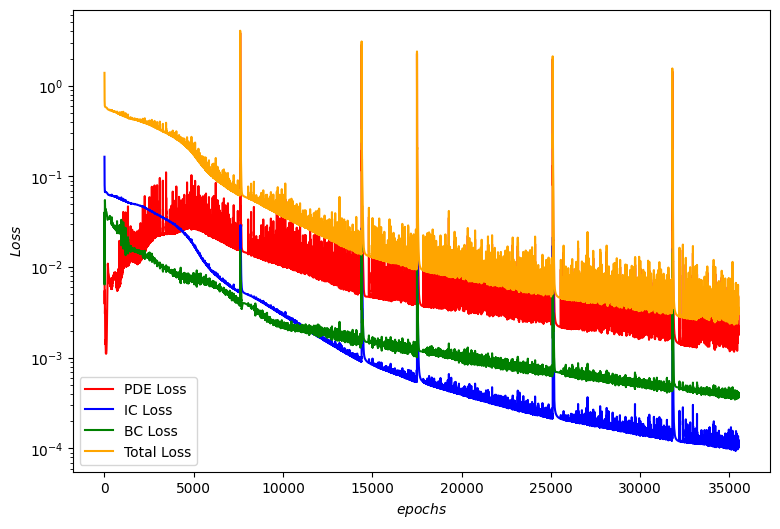

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(ODE_loss_hist)), ODE_loss_hist, color='r', label='PDE Loss')
ax.semilogy(range(len(IC_loss_hist)), IC_loss_hist, color='b',  label='IC Loss')
ax.semilogy(range(len(BC_loss_hist)), BC_loss_hist, color='g', label='BC Loss')
ax.semilogy(range(len(total_loss_hist)), total_loss_hist, color='orange',  label='Total Loss')
plt.legend()
ax.set_xlabel('$epochs$')
ax.set_ylabel('$Loss$');

## Functions

In [ ]:
def Crank_Nicolson(IC, P_x, P_t):
  if len(IC) != P_x:
    print('Lenth of array in IC different from P_x')
    return None

  nx = P_x  # número de pontos em x
  nt = P_t  # número de pontos em t
  a = 0
  b = 1
  t0 = 0
  tf = 0.25


  x = np.linspace(a, b, nx)
  t = np.linspace(t0, tf, nt)

  dx = (b - a)/(nx -1)
  dt = (tf - t0)/(nt-1)
  d = dt/(dx**2)

  UN = np.zeros((nt, nx), dtype=np.float64)

  # Condição inicial
  #for i in range (0, nx):
  #  UN[0, i] = np.sin(np.pi * x[i])

  UN[0,:]= IC


  A = np.zeros((nx - 2, nx - 2), dtype=np.float64)
  B = np.zeros((nx - 2, nx - 2), dtype=np.float64)
  b = np.zeros((nx - 2), dtype=np.float64)

  for j in range(0, (nx - 2)):
    if j == 0:
      A[j,j] = 2*(1 + d)
      A[j,j+1] = -d

      B[j,j] = 2*(1 - d)
      B[j,j+1] = d

    elif j == ((nx - 2) - 1):
      A[j, j-1] = -d
      A[j,j] = 2*(1 + d)

      B[j, j-1] = d
      B[j,j] = 2*(1 - d)

    else:
      A[j, j-1] = -d
      A [j,j] = 2*(1 + d)
      A[j, j+1] = -d

      B[j, j-1] = d
      B[j,j] = 2*(1 - d)
      B[j, j+1] = d


  for n in range(0, nt - 1):
    for i in range(0, nx - 2):
      b[i] = UN[n, i+1]
    b = np.matmul(B, b)
    b[0] = b[0] + d*(UN[n+1, 0] + UN[n,0])
    b[-1] = b[-1] + d*(UN[n+1, -1] + UN[n,-1])

    y = np.linalg.solve(A, b)

    for i in range(1, nx - 1):
      UN[n+1, i] = y[i - 1]

  return UN

In [ ]:
# DeepOnet Aprx
def DeepOnet(IC, P_x, P_t):
  sensors = P_x
  count = 0

  Y = np.zeros((sensors*P_t , 2))
  Ui_sample = []

  X_sample =  np.linspace(0, 1, sensors)
  T_sample = np.linspace(0, 0.25, P_t)


  # Matriz com todos os dados
  for i in range(0, P_t):
    for j in range(0, sensors):
      #print(f'{count} : [{t[i]} | {x[j]}]')
      Y[count][0] = T_sample[i]
      Y[count][1] = X_sample[j]
      Ui_sample.append(IC)
      count += 1

  Y = tf.convert_to_tensor(Y, dtype=tf.float32)
  Ui_sample = tf.convert_to_tensor(Ui_sample, dtype=tf.float32)

  S_Y = PI_DeepONet([Ui_sample, Y])

  Uapx_DON = np.zeros((P_t,sensors,))
  count = 0

  # Matriz com todos os dados
  for i in range(0, P_t):
    for j in range(0, sensors):
      #print(f'{count} : [{t[i]} | {x[j]}]')
      Uapx_DON[i][j] = S_Y[count]
      count += 1

  return Uapx_DON

In [ ]:
Rel_L2 = []

for i in range(0, 100):
  int_i = sensors*i
  int_f = sensors*(i+1)

  Uapx_DON = DeepOnet(Data_IC[1][int_i:int_f][1], P_x=sensors, P_t=30)
  Uapx_CN = Crank_Nicolson(Data_IC[2][int_i:int_f].numpy().reshape((sensors,)), P_x=sensors, P_t=30)

  Rel_L2.append(np.sqrt(np.sum((Uapx_DON - Uapx_CN)**2))/np.sqrt(np.sum((Uapx_CN)**2)))

  print(f'{i}: {Rel_L2[i]}')



0: 1.0040727141114814
1: 1.0040727141114814
2: 0.4361016506590605
3: 0.2475639343112049
4: 0.850999192228768
5: 0.17624477161235616
6: 0.07149866108681222
7: 0.07149866108681222
8: 0.48665277824988595
9: 0.10673601363405719
10: 0.4533724694158102
11: 0.24257034629026256
12: 0.1239568844488448
13: 0.5077450060006323
14: 0.15587356376437778
15: 0.3273097979009198
16: 0.9952693341047194
17: 0.5273132983549133
18: 0.29440215580617624
19: 0.14362150930379194
20: 0.16761930819467138
21: 0.07020491597156395
22: 0.845671232179872
23: 0.6319206381035902
24: 0.15038244355020752
25: 0.2318168915926244
26: 0.5077450060006323
27: 0.6962923220749745
28: 0.9364842278863501
29: 0.23591202756295906
30: 0.26031278291820803
31: 0.4361016506590605
32: 0.5132014227839765
33: 0.10453539328712869
34: 0.11786076304215506
35: 0.6611617285061826
36: 0.5138857294372484
37: 0.5511569837546624
38: 0.9364842278863501
39: 0.3058856485233708
40: 0.9215505437875138
41: 0.09531979481836819
42: 0.8593942775750577
43: 0.

<ipython-input-25-e0a3ebda134f>:10: RuntimeWarning: divide by zero encountered in scalar divide
  Rel_L2.append(np.sqrt(np.sum((Uapx_DON - Uapx_CN)**2))/np.sqrt(np.sum((Uapx_CN)**2)))


79: inf
80: 0.6147233125663625
81: 0.07889492926764
82: 0.13780049375454764
83: 0.7716018679762164
84: 0.5273132983549133
85: 0.07403334159833182
86: 0.41810445902134385
87: 221042548150998.9
88: 0.5077450060006323
89: 0.25220522145185603
90: 0.42905572646194523
91: 0.16892541239586548
92: 0.11516703599063913
93: 0.6990125860666804
94: 0.17624477161235616
95: 0.5901854569077374
96: 0.2908257976761646
97: 0.24203245517840086
98: 0.3004569352689907
99: 0.34640613606440557


In [ ]:
print(f'Mean L2 relaive norm {np.mean(Rel_L2)}')
#print(f'Std of the L2 relative norm {np.}')
print(f'Max L2 relaive norm {np.max(Rel_L2)}')
print(f'Min L2 relaive norm {np.min(Rel_L2)}')

Mean L2 relaive norm 0.4237854986491218
Max L2 relaive norm 1.04410360361148
Min L2 relaive norm 0.06368274642270788


In [ ]:
i = 42
int_i = sensors*i
int_f = sensors*(i+1)

X_sample =  np.linspace(0, 1, sensors)
T_sample = np.linspace(0, 0.25, 30)

Uapx_CN = Crank_Nicolson(Data_IC[2][int_i:int_f].numpy().reshape((sensors,)), P_x=sensors, P_t=30)
Uapx_DON = DeepOnet(Data_IC[1][int_i:int_f][1], P_x=sensors, P_t=30)

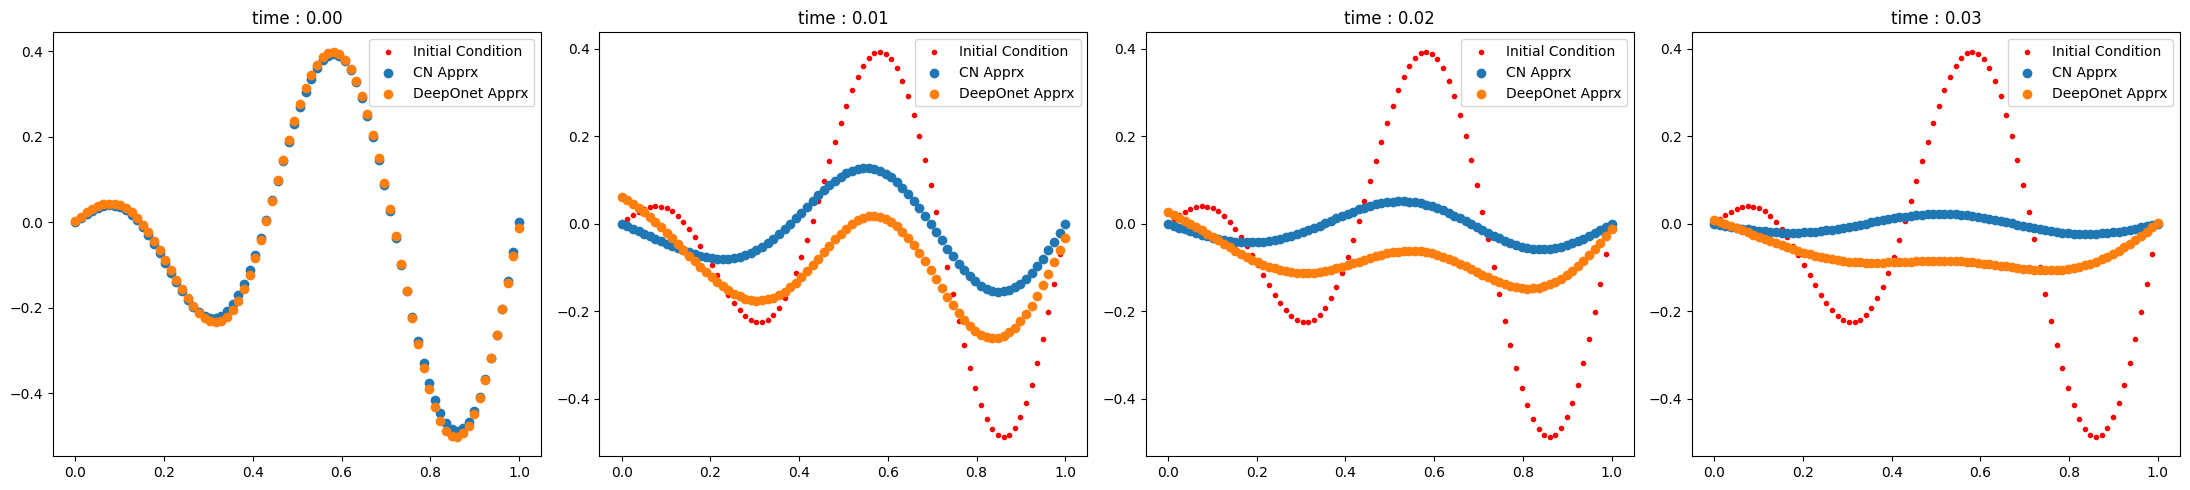

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

for i in range(0, 4):
  axs[i].scatter(X_sample, Data_IC[2][int_i:int_f], color='r', marker='.', label='Initial Condition')
  axs[i].scatter(X_sample, Uapx_CN[i,:], label='CN Apprx')
  axs[i].scatter(X_sample, Uapx_DON[i][:], label='DeepOnet Apprx')
  axs[i].set_title(f'time : {T_sample[i]:2.2f}')
  axs[i].legend()

plt.tight_layout()
plt.show()

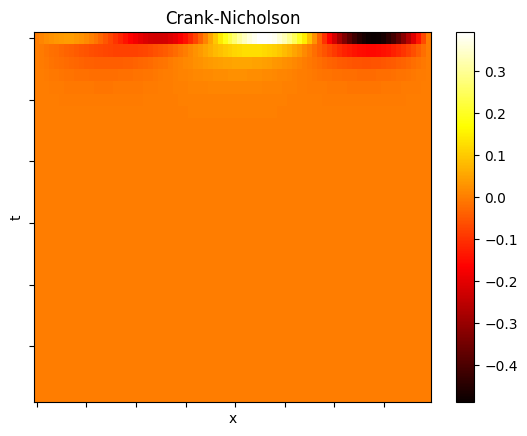

In [ ]:
plt.imshow(Uapx_CN, cmap='hot', aspect='auto')
plt.colorbar()
plt.title(f'Crank-Nicholson')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

Text(0, 0.5, 'x')

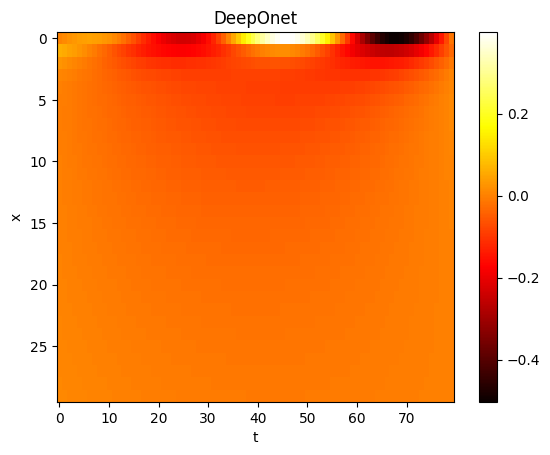

In [ ]:
plt.imshow(Uapx_DON, cmap='hot', aspect='auto')
plt.colorbar()
plt.title('DeepOnet')
plt.xlabel('t')
plt.ylabel('x')

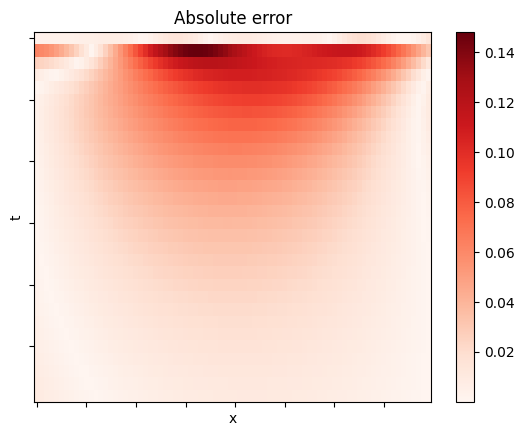

In [ ]:
plt.imshow(abs(Uapx_DON - Uapx_CN), cmap='Reds', aspect='auto')
plt.colorbar()
plt.title(f'Absolute error')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

# Test set

In [ ]:
P_t = 30

X_sample =  np.linspace(0, 1, sensors)
T_sample = np.linspace(0, 0.25, 30)

In [ ]:
u_sample, coef = crate_samples_cos(u_sample_num=100, sensors=sensors)

In [ ]:
def Sol_Anal(c1, c2, c3, c4, t, x):
  s1 = np.sin(c1*np.pi*x) * np.exp(-((np.pi * c1)**2) * t)
  s2 = np.sin(c2*np.pi*x) * np.exp(-((np.pi * c2)**2) * t)
  s3 = np.sin(c3*np.pi*x) * np.exp(-((np.pi * c3)**2) * t)
  s4 = np.sin(c4*np.pi*x) * np.exp(-((np.pi * c4)**2) * t)
  return (s1 + s2 + s3 + s4)/4

In [ ]:
Rel_L2_CN = []
Rel_L2_DON = []

for i in range(0, 100):

  c1, c2, c3, c4 = coef[f'{i}']
  IC = u_sample[f'{i}']

  UA = np.zeros((sensors, P_t))

  for k in range(0, len(X_sample)):
    for j in range(0, len(T_sample)):
      UA[k][j] = Sol_Anal(c1, c2, c3, c4, T_sample[j], X_sample[k])


  Uapx_DON = DeepOnet(IC, P_x=sensors, P_t=30)
  Uapx_CN = Crank_Nicolson(IC, P_x=sensors, P_t=30)

  Rel_L2_DON.append(np.sqrt(np.sum((Uapx_DON - UA.T)**2))/np.sqrt(np.sum((UA.T)**2)))
  Rel_L2_CN.append(np.sqrt(np.sum((Uapx_CN - UA.T)**2))/np.sqrt(np.sum((UA.T)**2)))


  print(f'{i}: DON {Rel_L2_DON[i]}; CN: {Rel_L2_CN[i]}')

0: DON 0.23531047777779066; CN: 0.02653148826309854
1: DON 0.30151852696179726; CN: 0.02518219209021482
2: DON 0.15267018909396388; CN: 0.03701883816621411
3: DON 0.4400231186031785; CN: 0.10019471248657043
4: DON 0.3310621999556017; CN: 0.047291138194892966
5: DON 0.1853393168558574; CN: 0.0027404754592880195
6: DON 0.1902882361543635; CN: 0.023656082605299826
7: DON 0.26121016355527316; CN: 0.048668441997667566
8: DON 0.14950435102407153; CN: 0.023842773127815506
9: DON 0.09558631015128698; CN: 0.0055142194372511935
10: DON 0.2130122043006217; CN: 0.0027404754592880148
11: DON 0.3418623722401688; CN: 0.08554444382910902
12: DON 0.4063597925878478; CN: 0.05357985396680522
13: DON 0.25556610204307123; CN: 0.02653148826309854
14: DON 0.5544592839338678; CN: 0.08450216540974637
15: DON 0.2353104777777906; CN: 0.02653148826309854
16: DON 0.647195186045555; CN: 0.09019327905343763
17: DON 0.7472390443167382; CN: 0.14787750699806598
18: DON 0.9144135487970201; CN: 0.13879566398441828
19: DO

<ipython-input-142-99c4eef0c82b>:19: RuntimeWarning: divide by zero encountered in scalar divide
  Rel_L2_DON.append(np.sqrt(np.sum((Uapx_DON - UA.T)**2))/np.sqrt(np.sum((UA.T)**2)))
<ipython-input-142-99c4eef0c82b>:20: RuntimeWarning: invalid value encountered in scalar divide
  Rel_L2_CN.append(np.sqrt(np.sum((Uapx_CN - UA.T)**2))/np.sqrt(np.sum((UA.T)**2)))


34: DON inf; CN: nan
35: DON 0.13880193427533383; CN: 0.01564393482657982
36: DON 0.11869357585563009; CN: 0.013621554823599235
37: DON 0.40628138015668763; CN: 0.04729113821673665
38: DON 0.2817916007898494; CN: 0.016246908384399135
39: DON 0.14315233139527503; CN: 0.023842773062521055
40: DON 0.11593343604761316; CN: 0.016246908384399027
41: DON 0.4081636836079097; CN: 0.024428661494497093
42: DON 0.8392277266096048; CN: 0.05357985396436484
43: DON 1.1434930922453364; CN: 0.11465845891988055
44: DON 0.28713104746431145; CN: 0.04269257299212648
45: DON 0.07160323909863907; CN: 0.010302582801122928
46: DON 0.29093161536219114; CN: 0.05487639853898999
47: DON 0.338818752208431; CN: 0.026337899374477714
48: DON 0.7303292522314541; CN: 0.04433127129154222
49: DON 0.1757804305008204; CN: 0.04648843847346198
50: DON 0.2553293630047676; CN: 0.03734103899230483
51: DON 0.12389121534426933; CN: 0.005516606985014295
52: DON 0.7691910913695943; CN: 0.05357985396680508
53: DON 0.2396796845124356;

In [ ]:
Rel_L2_DON.pop(34)

inf

In [ ]:
print(f'Mean L2 relaive norm {np.mean(Rel_L2_DON)}')
#print(f'Std of the L2 relative norm {np.}')
print(f'Max L2 relaive norm {np.max(Rel_L2_DON)}')
print(f'Min L2 relaive norm {np.min(Rel_L2_DON)}')

Mean L2 relaive norm 0.3749962937884364
Max L2 relaive norm 1.1434930922453364
Min L2 relaive norm 0.061736965469007685


In [ ]:
i = 85
c1, c2, c3, c4 = coef[f'{i}']
IC = u_sample[f'{i}']

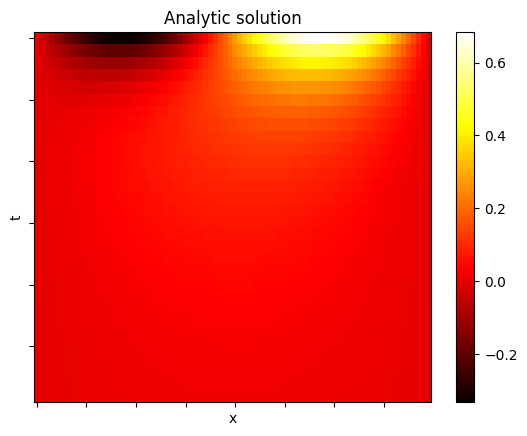

In [ ]:
UA = np.zeros((sensors, P_t))

x_domain = np.linspace(0, 1, sensors)
t_domain = np.linspace(0, 0.25, P_t)

for k in range(0, len(x_domain)):
  for j in range(0, len(t_domain)):
    UA[k][j] = Sol_Anal(c1, c2, c3, c4, t_domain[j], x_domain[k])

UA = UA.T

plt.imshow(UA, cmap='hot', aspect='auto')
plt.colorbar()
plt.title(f'Analytic solution')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

In [ ]:
Uapx_CN = Crank_Nicolson(IC, P_x=sensors, P_t=30)
Uapx_DON = DeepOnet(IC, P_x=sensors, P_t=30)

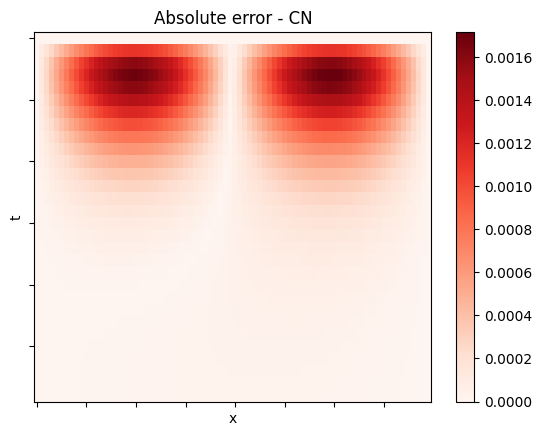

In [ ]:
plt.imshow(abs(UA - Uapx_CN), cmap='Reds', aspect='auto')
plt.colorbar()
plt.title(f'Absolute error - CN')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

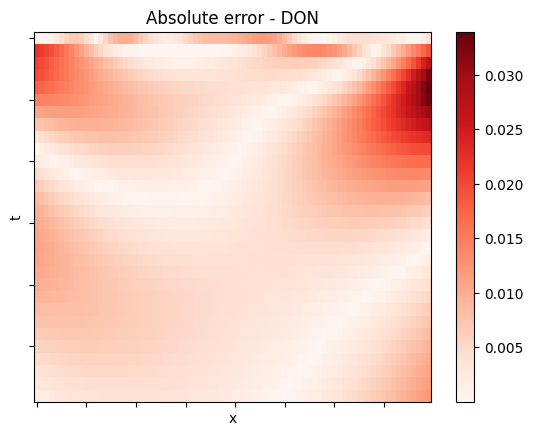

In [ ]:
plt.imshow(abs(UA - Uapx_DON), cmap='Reds', aspect='auto')
plt.colorbar()
plt.title(f'Absolute error - DON')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

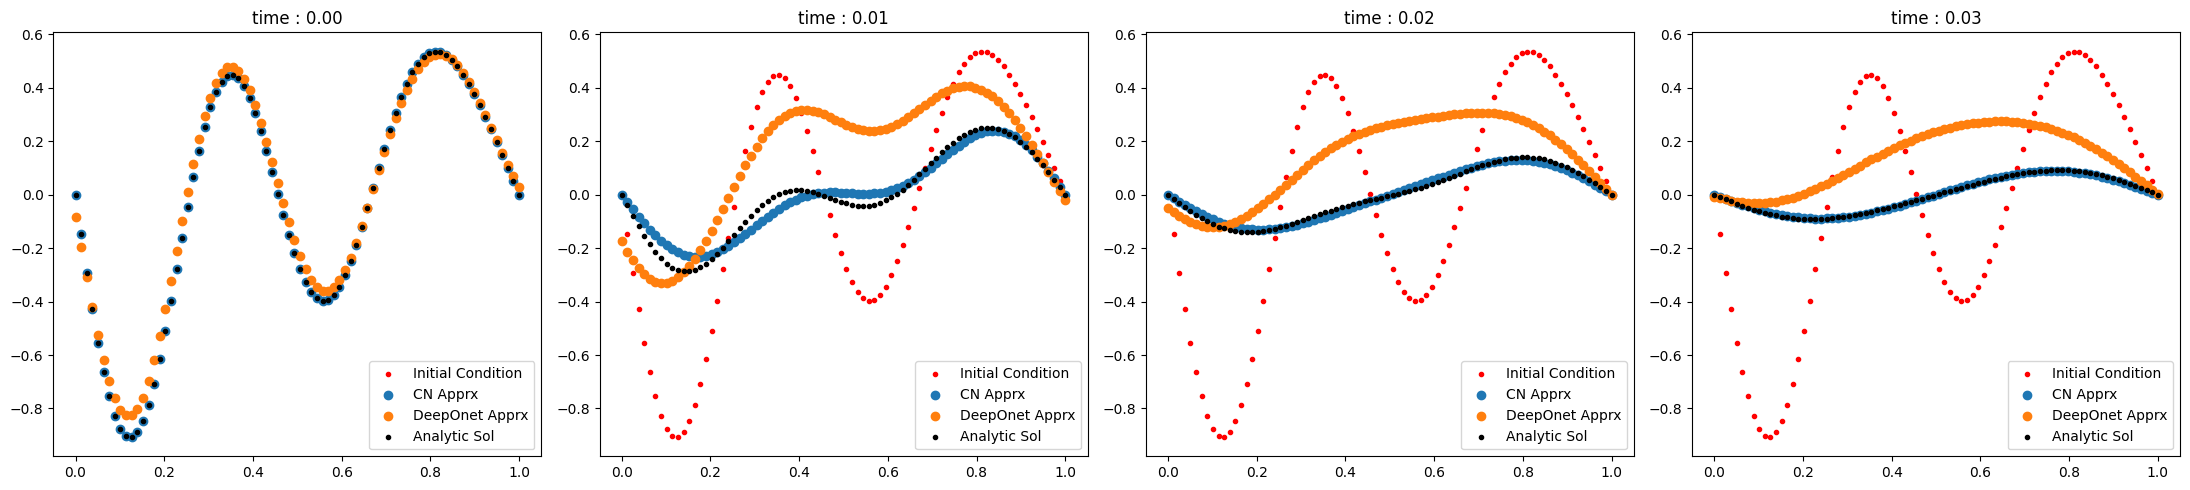

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

for i in range(0, 4):
  axs[i].scatter(X_sample, IC, color='r', marker='.', label='Initial Condition')
  axs[i].scatter(X_sample, Uapx_CN[i,:], label='CN Apprx')
  axs[i].scatter(X_sample, Uapx_DON[i][:], label='DeepOnet Apprx')
  axs[i].scatter(X_sample, UA[i,:], color='black', marker='.', label='Analytic Sol')
  axs[i].set_title(f'time : {T_sample[i]:2.2f}')
  axs[i].legend()

plt.tight_layout()
plt.show()

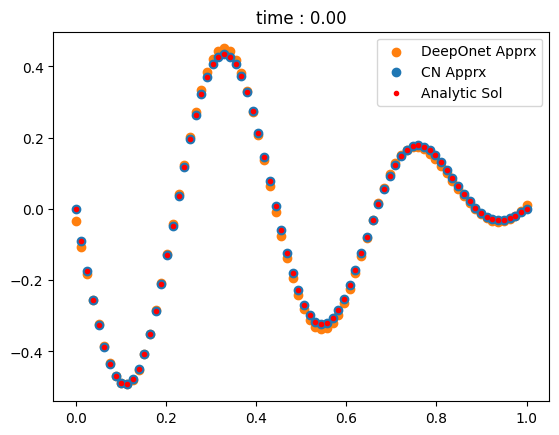

In [ ]:
time = 0

plt.scatter(X_sample, Uapx_DON[time][:],color='tab:orange', label='DeepOnet Apprx')
plt.scatter(X_sample, Uapx_CN[time][:],color='tab:blue' , label='CN Apprx')
plt.scatter(X_sample, UA[time][:], color='r', marker='.', label='Analytic Sol')
plt.title(f'time : {T_sample[time]:2.2f}')
plt.legend()

# Out of distribuition data

In [ ]:
x = np.linspace(0, 1, sensors)
IC = np.zeros((sensors,))
for i in range (0, sensors):
  IC[i] = np.sin(np.pi * x[i])

c1, c2, c3, c4 = 1, 1, 1, 1

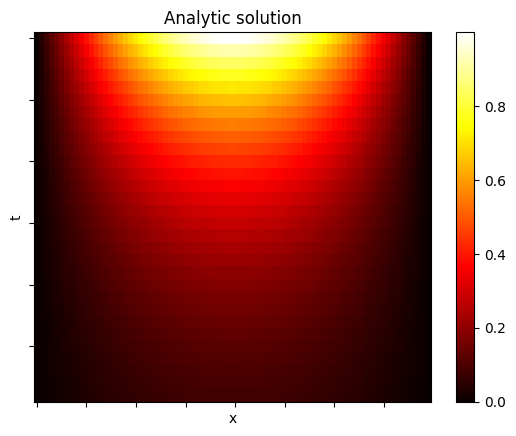

In [ ]:
UA = np.zeros((sensors, P_t))

x_domain = np.linspace(0, 1, sensors)
t_domain = np.linspace(0, 0.25, P_t)

for k in range(0, len(x_domain)):
  for j in range(0, len(t_domain)):
    UA[k][j] = Sol_Anal(c1, c2, c3, c4, t_domain[j], x_domain[k])

UA = UA.T

plt.imshow(UA, cmap='hot', aspect='auto')
plt.colorbar()
plt.title(f'Analytic solution')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

In [ ]:
Uapx_CN = Crank_Nicolson(IC, P_x=sensors, P_t=30)
Uapx_DON = DeepOnet(IC, P_x=sensors, P_t=30)

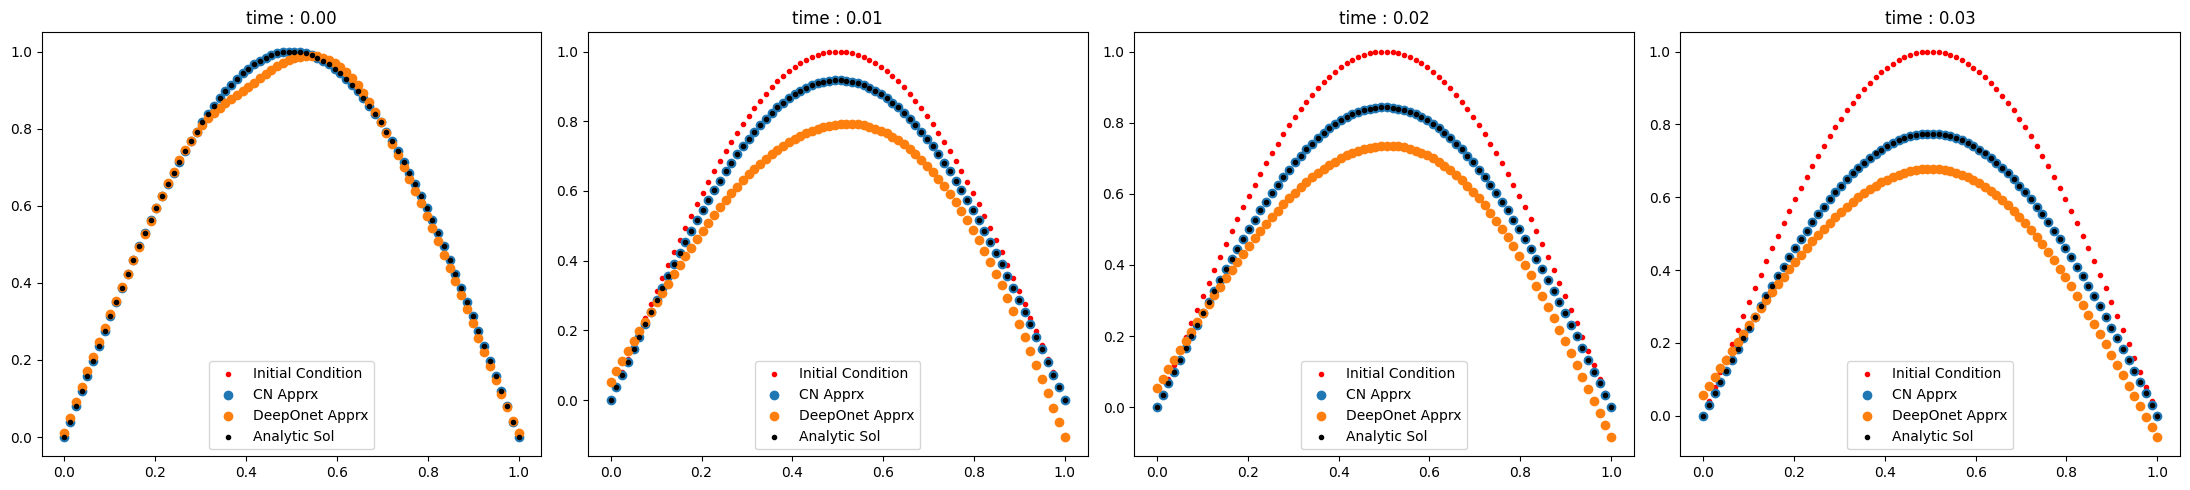

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

for i in range(0, 4):
  axs[i].scatter(X_sample, IC, color='r', marker='.', label='Initial Condition')
  axs[i].scatter(X_sample, Uapx_CN[i,:], label='CN Apprx')
  axs[i].scatter(X_sample, Uapx_DON[i][:], label='DeepOnet Apprx')
  axs[i].scatter(X_sample, UA[i,:], color='black', marker='.', label='Analytic Sol')
  axs[i].set_title(f'time : {T_sample[i]:2.2f}')
  axs[i].legend()

plt.tight_layout()
plt.show()

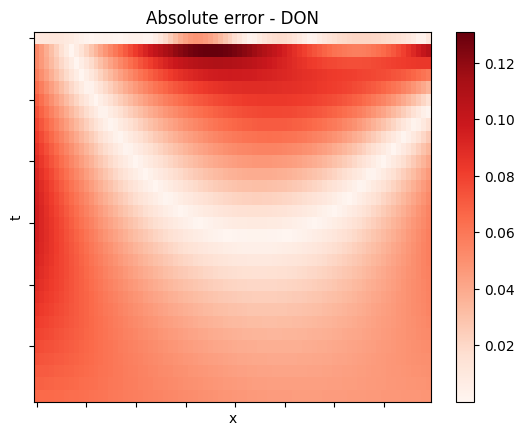

In [ ]:
plt.imshow(abs(UA - Uapx_DON), cmap='Reds', aspect='auto')
plt.colorbar()
plt.title(f'Absolute error - DON')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)

In [ ]:
np.sqrt(np.sum((Uapx_DON - UA)**2))/np.sqrt(np.sum((UA)**2))

0.15611315214296076

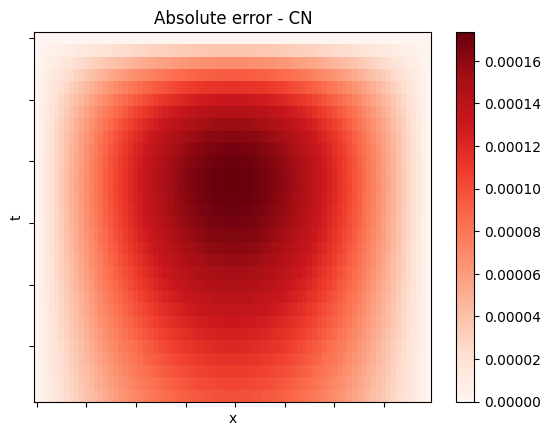

In [ ]:
plt.imshow(abs(UA - Uapx_CN), cmap='Reds', aspect='auto')
plt.colorbar()
plt.title(f'Absolute error - CN')
plt.xlabel('x')
plt.ylabel('t')
plt.tick_params(left = True, right = False , labelleft = False ,
                labelbottom = False, bottom = True)